In [ ]:
# Cargar paquetes
import sys
import numpy as np      # importamos numpy como np
import pandas as pd     # importamos pandas como pd
from contextlib import redirect_stdout

%matplotlib inline
import matplotlib.pyplot as plt # importamos matplotlib como plt
import seaborn as sns # importamos seaborn como sns
%config InlineBackend.figure_format = 'retina'

# Descompresión de los ficheros en nuestra carpeta de contenido
import os
import zipfile

# paquete apra la conexión y descarga de ficheros alojads en google drive
!pip install gdown
import gdown

!pip install missingno
import missingno as msno

!pip install plotly
import plotly
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objs as go
pyo.init_notebook_mode()
import plotly.figure_factory as ff

from sklearn.preprocessing import OrdinalEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Models LR, NB, RF, SVM, DT, KNN
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

# Import KMeans
from sklearn.cluster import KMeans

En primer lugar vamos a montar Google Drive para guardar los conjuntos de datos que se generen y no perderlos. De esta manera podemos recuperarlos más tarde para seguir con el estudio.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
path = '/content/drive/MyDrive/Water'

Vamos a establecer los estilos para los gráficos.

In [ ]:
sns.set_style("darkgrid", {"grid.color": "violet", "grid.linestyle": "--"})

Función  para crear gráficos de barras con conteo de frecuencias.

In [ ]:
def bar_plot(data, col, title, label, color):
    order_cat = data[col].value_counts().index

    # Create a bar plot with the frequency of the categories
    plt.figure(figsize=(10,10))

    # If number of categories is greater than 5, then plot a barh plot
    if len(order_cat) > 4:
        graph = sns.countplot(data=data, y=col, order=order_cat, palette=color, hue=col)
        plt.xlabel(label)
        plt.ylabel(col)
        # Plot the frequency on top of the bars (number of cases)
        for p in graph.patches:
            plt.text(p.get_width(), p.get_y() + 0.55*p.get_height(),'{}'.format(p.get_width()), ha='left', va='center')
    else:
        graph = sns.countplot(data=data, x=col, order=order_cat, palette=color, hue=col)
        plt.xlabel(col)
        plt.ylabel(label)
        # Plot the frequency on top of the bars
        for p in graph.patches:
            plt.text(p.get_x() + 0.55*p.get_width(), p.get_height(),'{}'.format(p.get_height()), ha='center', va='bottom')

    plt.title(title)
    plt.xticks(rotation=0)

    # Save the plot to a file
    plt.savefig(f'{path}/plots/plot_{title}.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

Descargamos ahora los datos que vamos a utilizar.

In [ ]:
# Descarganos fichero comprimido
id = "1P7N99cfufZXzon8AyoDPmzfSFtRwpFg0"
gdown.download(id=id, output="water.zip")
# Descomprimimos
#local_zip = '/content/water.zip'
local_zip = f'{path}/water.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(path)
zip_ref.close()

Downloading...
From (original): https://drive.google.com/uc?id=1P7N99cfufZXzon8AyoDPmzfSFtRwpFg0
From (redirected): https://drive.google.com/uc?id=1P7N99cfufZXzon8AyoDPmzfSFtRwpFg0&confirm=t&uuid=b9ac4906-9ab9-4053-bb80-6eedd1a75f2d
To: /content/water.zip
100%|██████████| 110M/110M [00:04<00:00, 25.9MB/s]


In [ ]:
# Cargamos
waterdf = pd.read_csv(f'{path}/Water Quality Prediction.csv')

# Vemos las primeras cinco muestras
waterdf.head(5)

Index        pH      Iron   Nitrate    Chloride           Lead      Zinc  \
0      0  8.332988  0.000083  8.605777  122.799772   3.710000e-52  3.434827   
1      1  6.917863  0.000081  3.734167  227.029851   7.850000e-94  1.245317   
2      2  5.443762  0.020106  3.816994  230.995630   5.290000e-76  0.528280   
3      3  7.955339  0.143988  8.224944  178.129940  4.000000e-176  4.027879   
4      4  8.091909  0.002167  9.925788  186.540872  4.170000e-132  3.807511   

            Color  Turbidity  Fluoride  ...  Chlorine     Manganese  \
0       Colorless   0.022683  0.607283  ...  3.708178  2.270000e-15   
1    Faint Yellow   0.019007  0.622874  ...  3.292038  8.020000e-07   
2    Light Yellow   0.319956  0.423423  ...  3.560224  7.007989e-02   
3  Near Colorless   0.166319  0.208454  ...  3.516907  2.468295e-02   
4    Light Yellow   0.004867  0.222912  ...  3.177849  3.296139e-03   

   Total Dissolved Solids  Source  Water Temperature  Air Temperature  \
0              332.118789     NaN                NaN        43.493324   
1              284.641984    Lake          15.348981        71.220586   
2              570.054094   River          11.643467        44.891330   
3              100.043838  Ground          10.092392        60.843233   
4              168.075545  Spring          15.249416        69.336671   

      Month   Day  Time of Day  Target  
0   January  29.0          4.0       0  
1  November  26.0         16.0       0  
2   January  31.0          8.0       0  
3     April   1.0         21.0       0  
4      June  29.0          7.0       0  

[5 rows x 24 columns]

In [ ]:
# Eliminamos la variable que identifica la muestra
waterdf = waterdf.drop(columns=['Index', 'Month', 'Day', 'Time of Day'])

# Vemos las primeras cinco muestras
waterdf.head(5)

pH      Iron   Nitrate    Chloride           Lead      Zinc  \
0  8.332988  0.000083  8.605777  122.799772   3.710000e-52  3.434827   
1  6.917863  0.000081  3.734167  227.029851   7.850000e-94  1.245317   
2  5.443762  0.020106  3.816994  230.995630   5.290000e-76  0.528280   
3  7.955339  0.143988  8.224944  178.129940  4.000000e-176  4.027879   
4  8.091909  0.002167  9.925788  186.540872  4.170000e-132  3.807511   

            Color  Turbidity  Fluoride    Copper      Odor     Sulfate  \
0       Colorless   0.022683  0.607283  0.144599  1.626212   87.266538   
1    Faint Yellow   0.019007  0.622874  0.437835  1.686049  144.010981   
2    Light Yellow   0.319956  0.423423  0.431588  3.414619  275.702107   
3  Near Colorless   0.166319  0.208454  0.239451       NaN  147.163233   
4    Light Yellow   0.004867  0.222912  0.616574  0.795310  175.275175   

   Conductivity  Chlorine     Manganese  Total Dissolved Solids  Source  \
0    471.683357  3.708178  2.270000e-15              332.118789     NaN   
1    432.844908  3.292038  8.020000e-07              284.641984    Lake   
2    990.201209  3.560224  7.007989e-02              570.054094   River   
3    237.028468  3.516907  2.468295e-02              100.043838  Ground   
4    385.025855  3.177849  3.296139e-03              168.075545  Spring   

   Water Temperature  Air Temperature  Target  
0                NaN        43.493324       0  
1          15.348981        71.220586       0  
2          11.643467        44.891330       0  
3          10.092392        60.843233       0  
4          15.249416        69.336671       0

In [ ]:
# Create a new folder to store the output files
if not os.path.exists(f'{path}/plots'):
    os.makedirs(f'{path}/plots')

## Definición del problema

El problema propuesto en este notebook es estudiar la potabilidad del agua utilizando propiedades químicas y físicas.

## Objetivos

El objetivo principal es clasificar el agua en potable o no potable utilizando la información de las diferentes propiedades físicas y químicas. Para abordar este objetivo plateo la utilización de las siguientes técnicas:
<ol>
    <li>Análisis Exploratorio de Datos (EDA) para entender la distribución de las valoraciones, identificar patrones y tendencias</li>
    <li>Preparación de los datos: limpieza de los datos (manejo de valores nulos y duplicados), transformación de variables categóricas, normalización o estandarización de variables numéricas. </li>
    <li>Modelado predictivo: desarrollo y comparación de diferentes técnicas de ML. Estos modelos se evaluarán con las métricas accuracy, AUC ROC, precisión, recall, f1-score.</li>
</ol>

## Análisis exploratorio de los datos

In [ ]:
print(waterdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   pH                      1028344 non-null  float64 
 1   Iron                    1041584 non-null  float64 
 2   Nitrate                 1029880 non-null  float64 
 3   Chloride                1017741 non-null  float64 
 4   Lead                    1043891 non-null  float64 
 5   Zinc                    1020900 non-null  float64 
 6   Color                   1047594 non-null  category
 7   Turbidity               1039881 non-null  float64 
 8   Fluoride                1015357 non-null  float64 
 9   Copper                  1013693 non-null  float64 
 10  Odor                    1017243 non-null  float64 
 11  Sulfate                 1014050 non-null  float64 
 12  Conductivity            1019772 non-null  float64 
 13  Chlorine                1038413 non-null  

In [ ]:
# Select the object columns
object_columns = waterdf.select_dtypes(include='object').columns

#Transform the object columns to category
waterdf[object_columns] = waterdf[object_columns].astype('category')

# Check the data types
print(waterdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 20 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   pH                      1028344 non-null  float64 
 1   Iron                    1041584 non-null  float64 
 2   Nitrate                 1029880 non-null  float64 
 3   Chloride                1017741 non-null  float64 
 4   Lead                    1043891 non-null  float64 
 5   Zinc                    1020900 non-null  float64 
 6   Color                   1047594 non-null  category
 7   Turbidity               1039881 non-null  float64 
 8   Fluoride                1015357 non-null  float64 
 9   Copper                  1013693 non-null  float64 
 10  Odor                    1017243 non-null  float64 
 11  Sulfate                 1014050 non-null  float64 
 12  Conductivity            1019772 non-null  float64 
 13  Chlorine                1038413 non-null  

In [ ]:
print(waterdf.shape)

(1048575, 20)


El dataset contiene 1048575 muestras y 20 variables.

In [ ]:
waterdf.describe(include=['category'])

Color   Source
count     1047594  1033040
unique          5        8
top     Colorless     Well
freq       326033   129654

In [ ]:
waterdf.describe()

pH          Iron       Nitrate      Chloride           Lead  \
count  1.028344e+06  1.041584e+06  1.029880e+06  1.017741e+06   1.043891e+06   
mean   7.449869e+00  1.139646e-01  6.078584e+00  1.818660e+02   1.291635e-03   
std    8.478455e-01  4.433188e-01  3.131874e+00  6.576657e+01   3.030129e-02   
min    2.058008e+00  2.050000e-53  2.861727e-01  2.941350e+01   0.000000e+00   
25%    6.914812e+00  8.950000e-06  3.952811e+00  1.374347e+02  8.290000e-123   
50%    7.452940e+00  2.054149e-03  5.564798e+00  1.747464e+02   1.520000e-62   
75%    8.001406e+00  4.977795e-02  7.584930e+00  2.156446e+02   2.820000e-27   
max    1.289196e+01  1.574860e+01  7.307293e+01  1.430549e+03   3.503948e+00   

               Zinc     Turbidity      Fluoride        Copper          Odor  \
count  1.020900e+06  1.039881e+06  1.015357e+06  1.013693e+06  1.017243e+06   
mean   1.528928e+00  4.835915e-01  9.410137e-01  4.939443e-01  1.772788e+00   
std    1.505436e+00  8.614735e-01  7.924903e-01  5.662430e-01  1.051316e+00   
min    6.350000e-07  1.410000e-14  4.550000e-06  2.100000e-09  1.100125e-02   
25%    4.127921e-01  3.692472e-02  3.706065e-01  1.260900e-01  8.772584e-01   
50%    1.074800e+00  1.997574e-01  7.654291e-01  3.389322e-01  1.744323e+00   
75%    2.214154e+00  5.928613e-01  1.318265e+00  6.789152e-01  2.611824e+00   
max    2.836867e+01  1.929611e+01  1.285171e+01  1.139056e+01  4.141991e+00   

            Sulfate  Conductivity      Chlorine     Manganese  \
count  1.014050e+06  1.019772e+06  1.038413e+06  1.029236e+06   
mean   1.446009e+02  4.248376e+02  3.236978e+00  9.352826e-02   
std    6.672156e+01  1.897561e+02  7.150808e-01  4.403703e-01   
min    1.194073e+01  1.305482e+01  9.994110e-01  1.380000e-46   
25%    9.746143e+01  2.863260e+02  2.737515e+00  2.060000e-06   
50%    1.339778e+02  3.970023e+02  3.198937e+00  5.372950e-04   
75%    1.803459e+02  5.333383e+02  3.685177e+00  1.369394e-02   
max    1.393433e+03  1.891516e+03  1.068842e+01  2.374086e+01   

       Total Dissolved Solids  Water Temperature  Air Temperature  \
count            1.048277e+06       1.018887e+06     1.043272e+06   
mean             2.647872e+02       1.915360e+01     6.003251e+01   
std              1.543697e+02       1.137963e+01     1.808397e+01   
min              1.064299e-02       6.661938e-01    -3.387091e+01   
25%              1.318069e+02       1.135982e+01     4.784209e+01   
50%              2.635694e+02       1.646738e+01     6.002168e+01   
75%              3.949597e+02       2.386571e+01     7.223478e+01   
max              5.797995e+02       2.430051e+02     1.440785e+02   

             Target  
count  1.048575e+06  
mean   2.295821e-01  
std    4.205643e-01  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00

Target
0    0.770418
1    0.229582
Name: proportion, dtype: float64

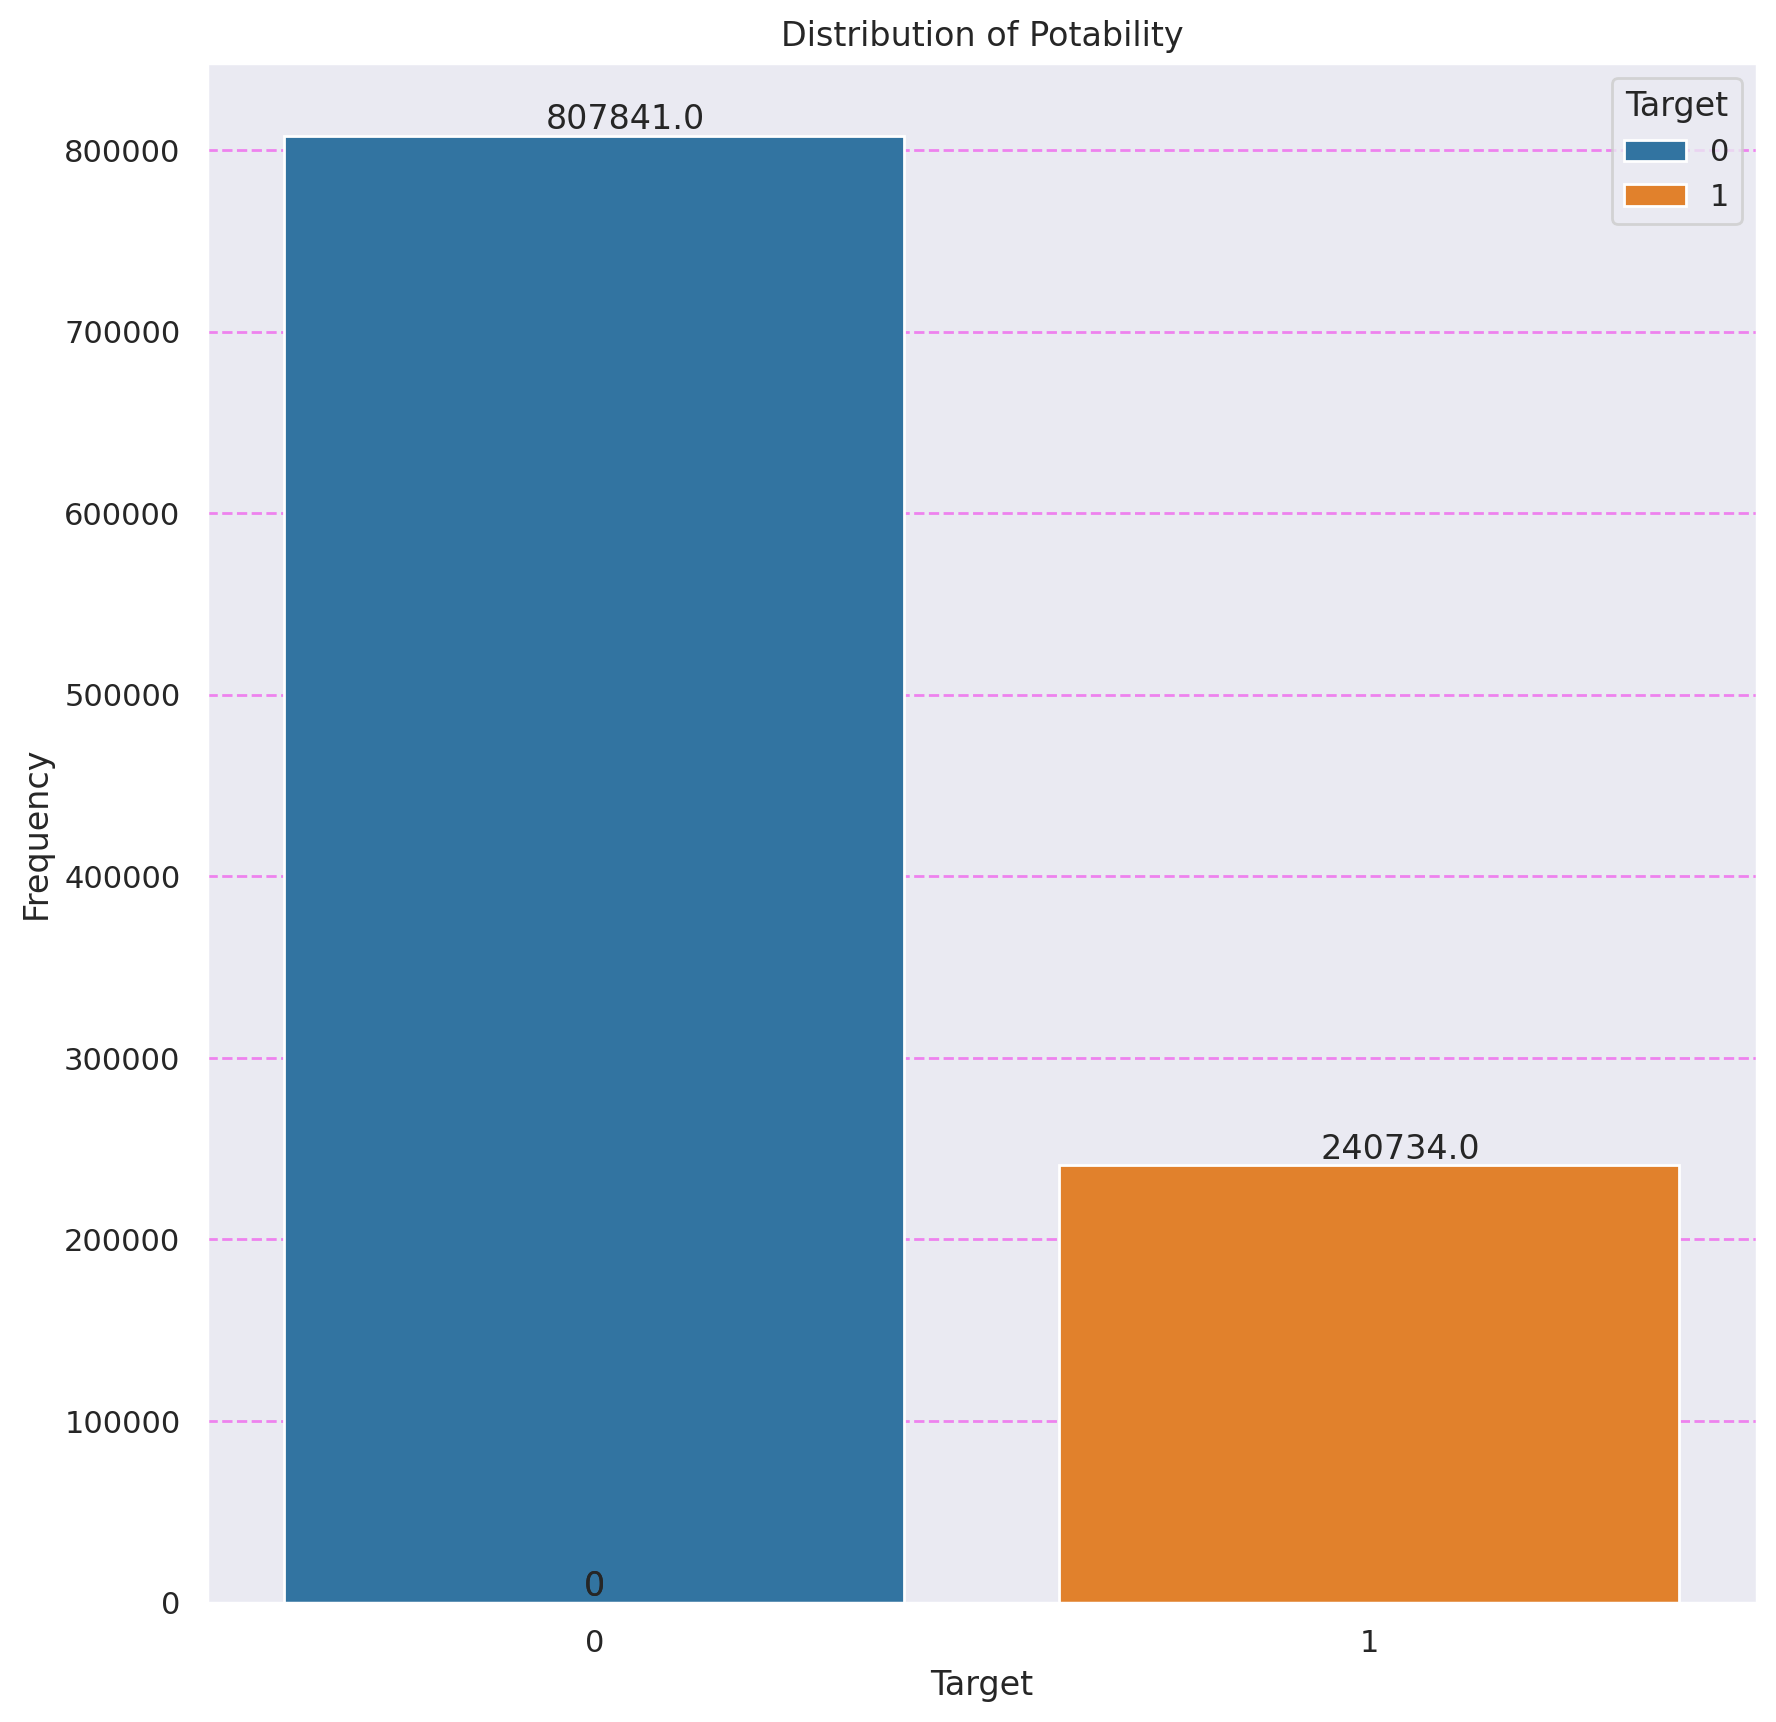

In [ ]:
# Check the distribution of the target variable
bar_plot(waterdf, 'Target', 'Distribution of Potability', 'Frequency', 'tab10')

# 0 potable, 1 not potable
waterdf['Target'].value_counts(normalize=True)

El 77,04% de las muestras son de agua potable, mientras que el 22,96% son muestras de agua no potable.

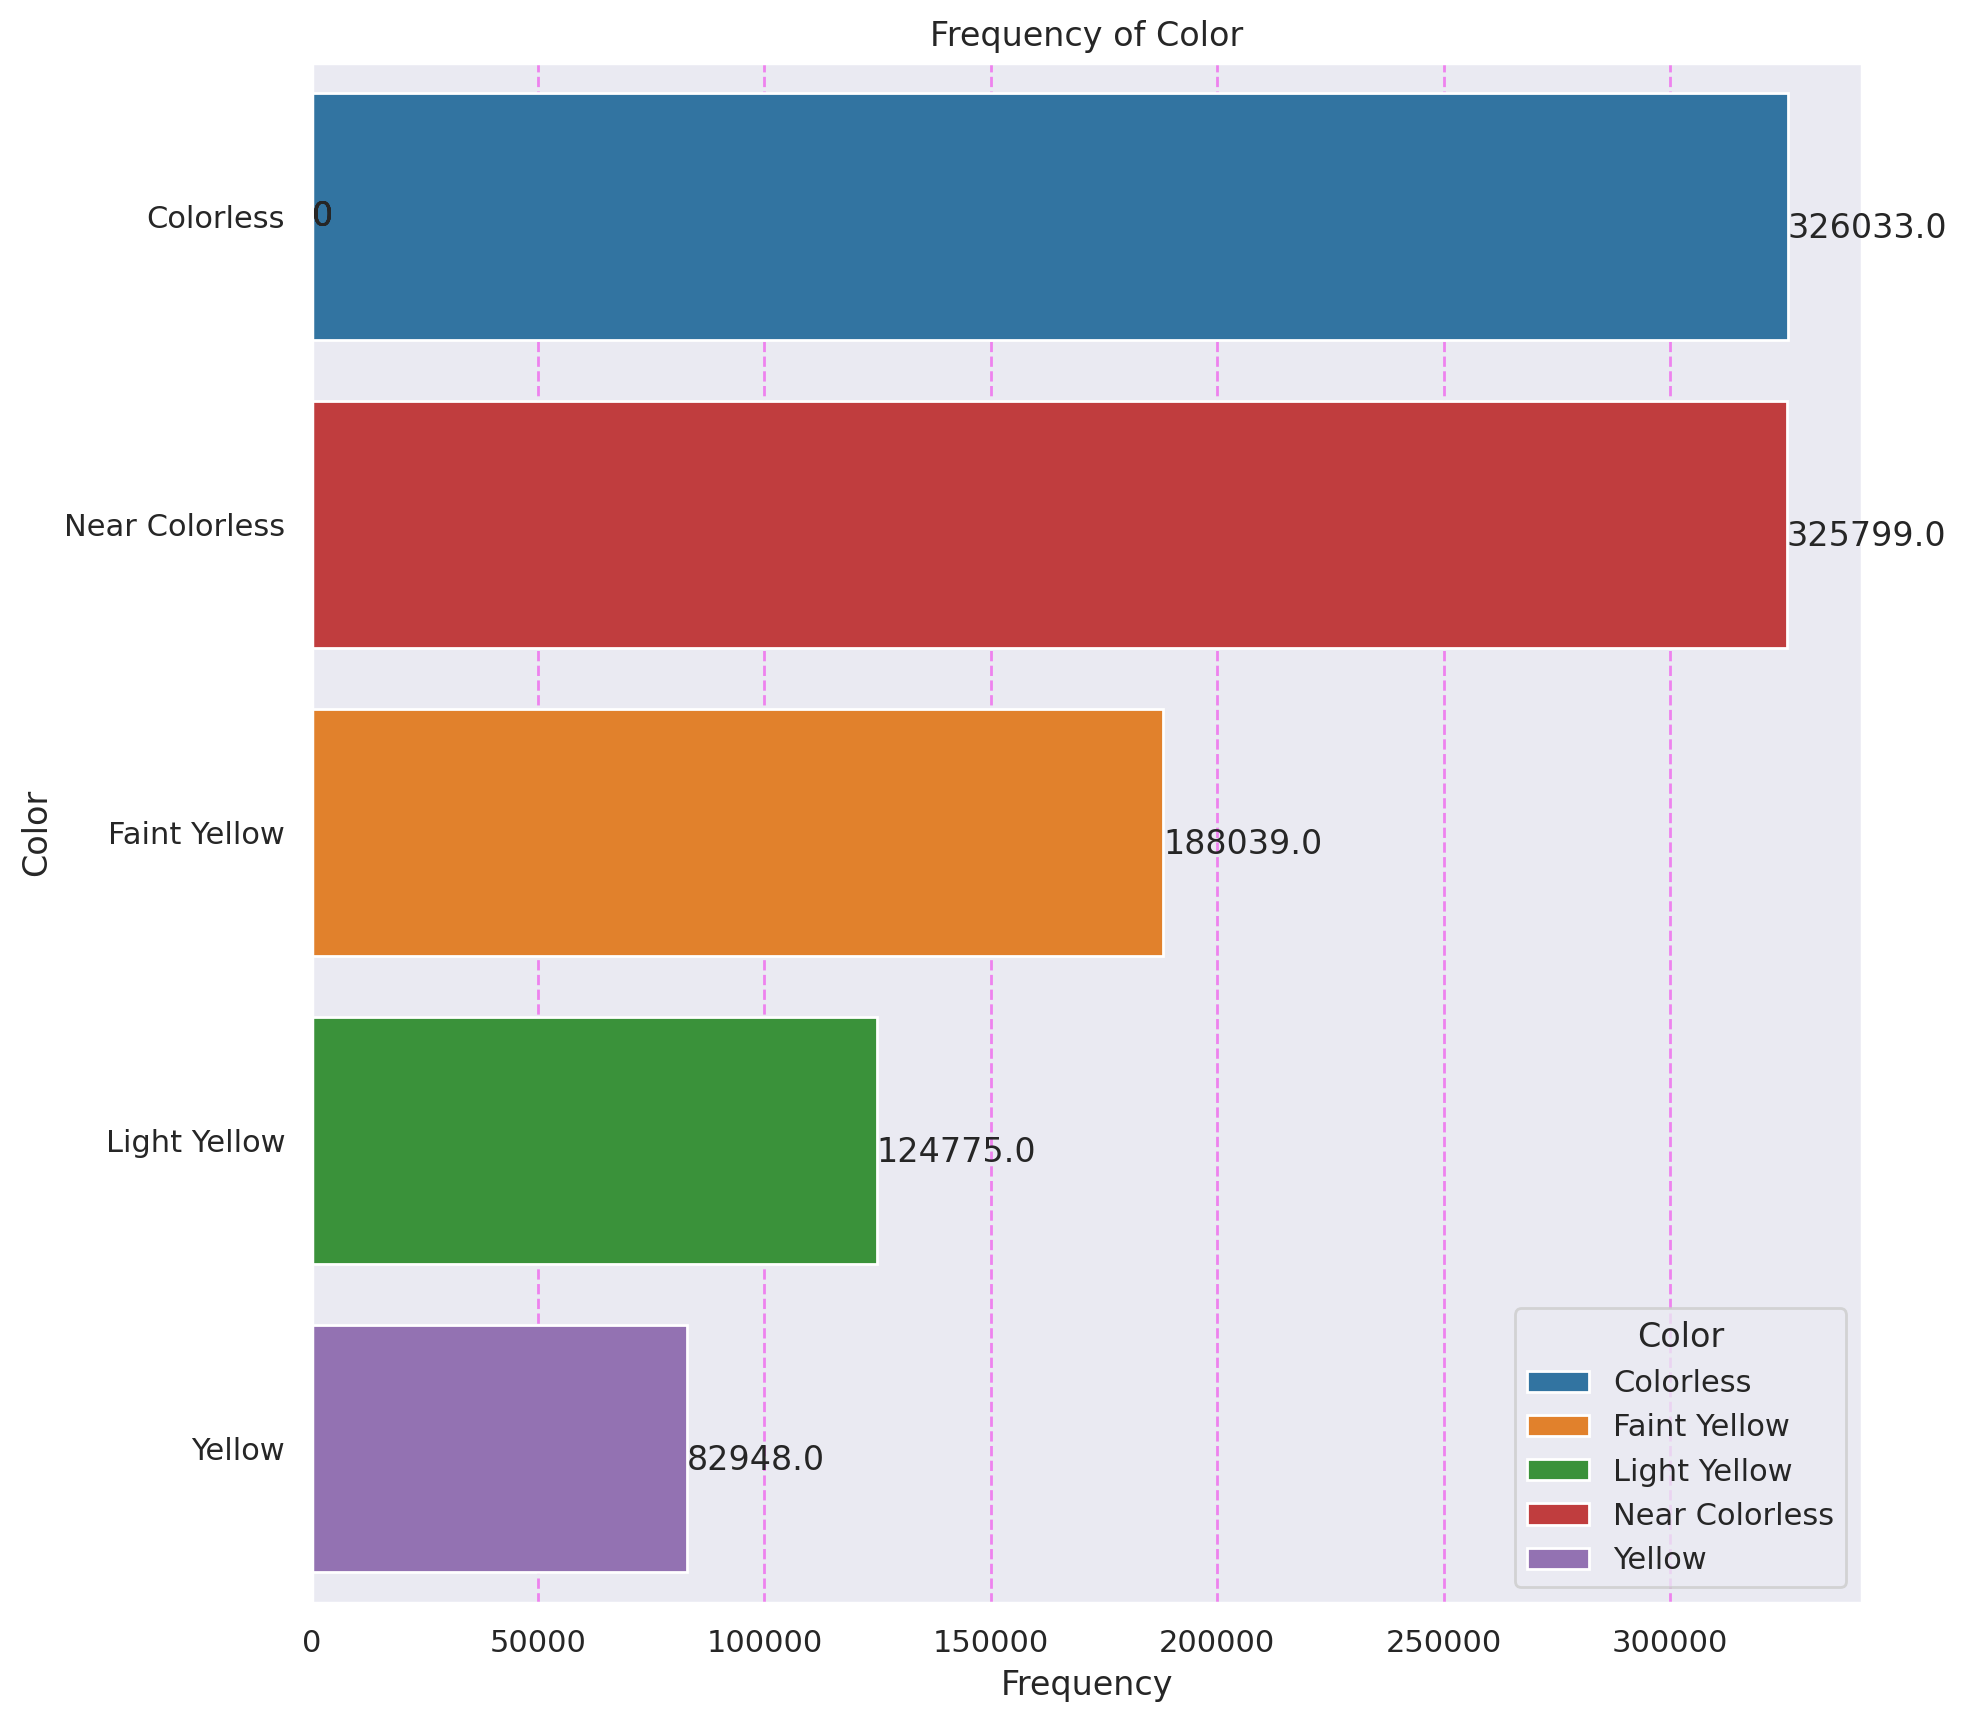

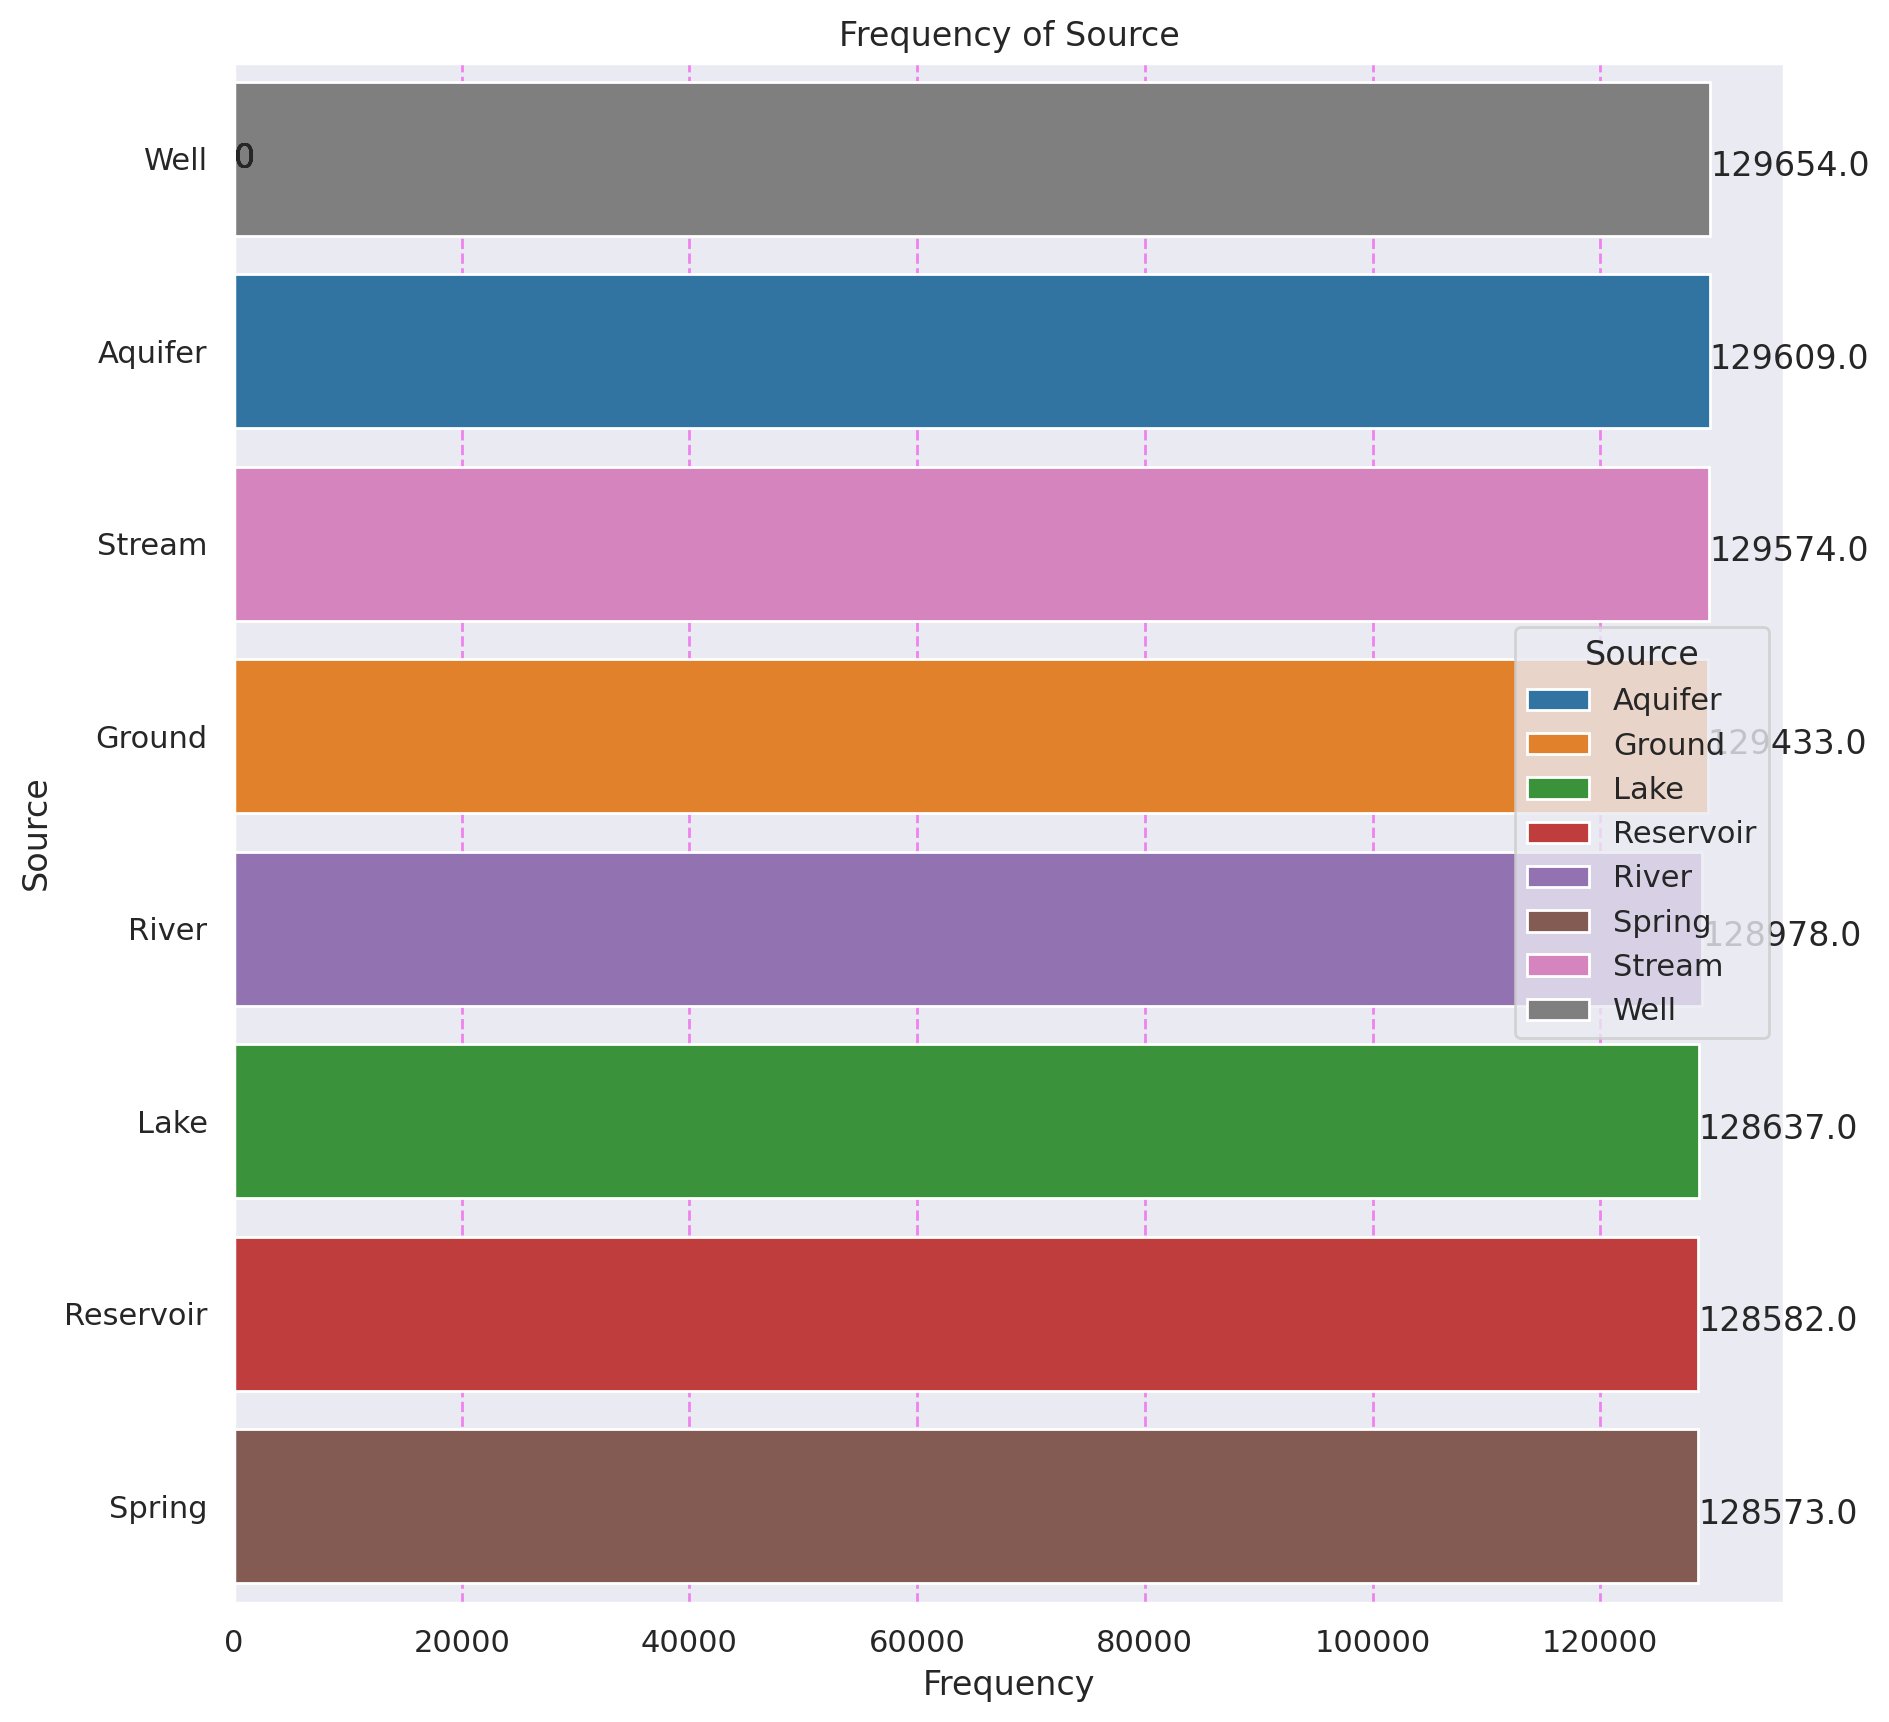

In [ ]:
categorical_columns = waterdf.select_dtypes(include=['object', 'category']).columns

# For each categorical column, create a frequency table
for col in categorical_columns:
    table = pd.DataFrame(waterdf[col].value_counts().sort_index(ascending=False))
    table.columns = ['F_ABS']
    table['F_ABS_AC'] = table['F_ABS'].cumsum()
    # Add the relative frequency and percentage columns
    table['F_REL'] = round(table['F_ABS']/(table['F_ABS'].sum()), 4)
    table['F_REL_AC'] = round(table['F_REL'].cumsum(), 4)
    table['%'] = round(table['F_REL']*100,2)
    table['%_AC'] = round(table['%'].cumsum(), 2)

    order_cat = waterdf[col].value_counts().index
    table = table.reindex(order_cat)

    # Create a bar plot with the frequency of the categories
    bar_plot(waterdf, col, f'Frequency of {col}', 'Frequency', 'tab10')

En estas figuras se puede observar que la mayoría de las muestras son incoloras y las muestras proceden de fuentes muy variadas, todas ellas con valores similares de número de muestras.

A continuación comprobamos la asimetría de las diferentes variables numéricas:

In [ ]:
# Check the skewness of the features. If the skewness is close to 0, then the feature is normally distributed
# Select the numerical columns
numerical_columns = waterdf.select_dtypes(include=[np.number]).columns
# Calculate the skewness of the numerical columns
skewness = waterdf[numerical_columns].drop('Target', axis=1).skew()
print(skewness)

pH                        -0.101219
Iron                       9.019744
Nitrate                    2.264632
Chloride                   1.600794
Lead                      45.642222
Zinc                       1.970113
Turbidity                  4.787395
Fluoride                   2.133959
Copper                     3.232226
Odor                       0.173568
Sulfate                    1.679431
Conductivity               0.887872
Chlorine                   0.695014
Manganese                  9.644579
Total Dissolved Solids     0.053481
Water Temperature          1.978860
Air Temperature           -0.002145
dtype: float64


El análisis de asimetría de las variables del dataset revela diversas distribuciones de los datos. La variable pH y Air Temperature tienen una ligera asimetría negativa (-0.101 y -0.002), indicando una distribución casi simétrica. Por otro lado, Iron, Lead y Manganese muestran una asimetría extremadamente alta (9.020, 45.642 y 9.645, respectivamente), sugiriendo una distribución altamente sesgada hacia la derecha, con valores atípicos significativos en el extremo superior. En el caso de Nitrate, Chloride, Zinc, Turbidity, Fluoride, Copper, Sulfate, y Water Temperature también presentan asimetrías positivas (2.265, 1.601, 1.970, 4.787, 2.134, 3.232, 1.679, y 1.979 respectivamente), indicando distribuciones sesgadas hacia la derecha aunque mucho menos pronunciadas. Finalmente, las variables Odor, Conductivity, Chlorine y Total Dissolved Solids presentan una asimetrías moderadas, con valores de 0.174, 0.888, 0.695 y 0.053 respectivamente, indicando distribuciones relativamente simétricas aunque con ligeras desviaciones.

Estos resultados indican que muchas de las variables presentan distribuciones asimétricas significativas, lo que requiere transformaciones adicionales para normalizar los datos antes de aplicar algoritmos de machine learning que asumen distribuciones normales.

array([[<Axes: title={'center': 'pH'}>, <Axes: title={'center': 'Iron'}>,
        <Axes: title={'center': 'Nitrate'}>,
        <Axes: title={'center': 'Chloride'}>],
       [<Axes: title={'center': 'Lead'}>,
        <Axes: title={'center': 'Zinc'}>,
        <Axes: title={'center': 'Turbidity'}>,
        <Axes: title={'center': 'Fluoride'}>],
       [<Axes: title={'center': 'Copper'}>,
        <Axes: title={'center': 'Odor'}>,
        <Axes: title={'center': 'Sulfate'}>,
        <Axes: title={'center': 'Conductivity'}>],
       [<Axes: title={'center': 'Chlorine'}>,
        <Axes: title={'center': 'Manganese'}>,
        <Axes: title={'center': 'Total Dissolved Solids'}>,
        <Axes: title={'center': 'Water Temperature'}>],
       [<Axes: title={'center': 'Air Temperature'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

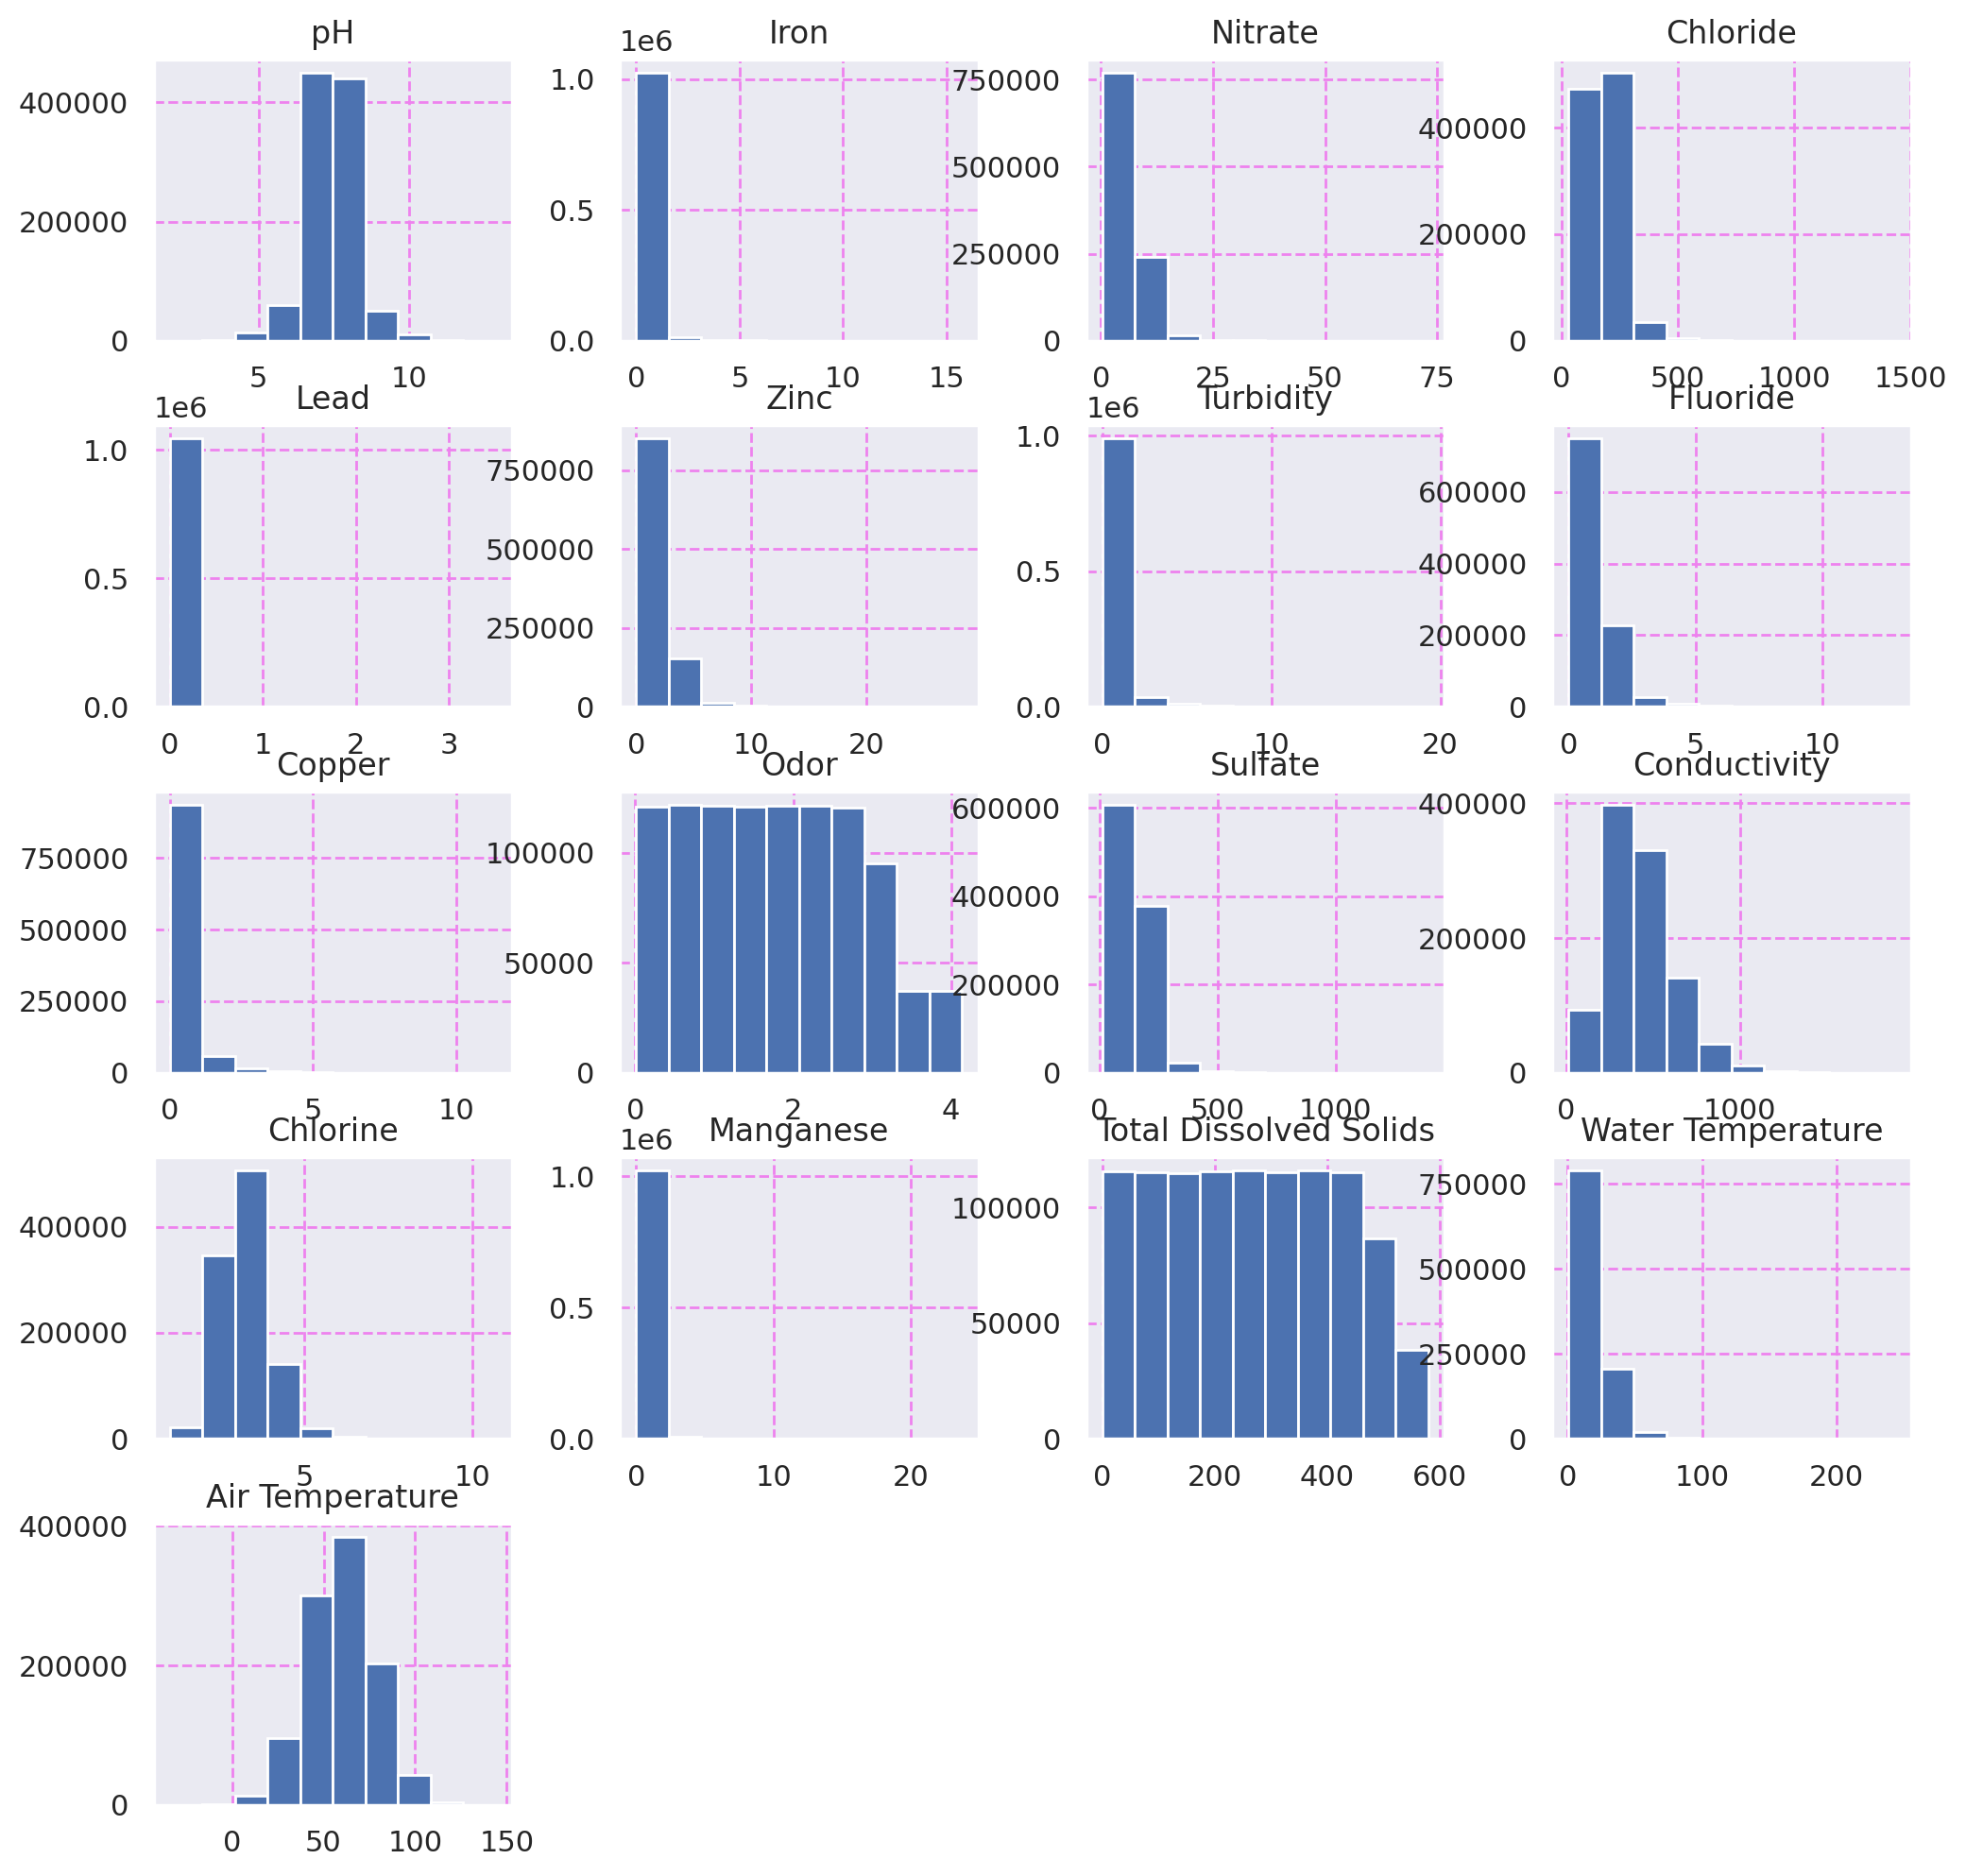

In [ ]:
waterdf[numerical_columns].drop('Target', axis=1).hist(figsize=(12,12))

Finalmente, estudiamos las correlaciones entre las variables:

In [ ]:
# Check the correlation between the numerical features
waterdf[numerical_columns].corr()

pH      Iron   Nitrate  Chloride      Lead  \
pH                      1.000000 -0.011121 -0.010350 -0.014534 -0.002800   
Iron                   -0.011121  1.000000  0.052961  0.067754  0.012198   
Nitrate                -0.010350  0.052961  1.000000  0.065066  0.010013   
Chloride               -0.014534  0.067754  0.065066  1.000000  0.013872   
Lead                   -0.002800  0.012198  0.010013  0.013872  1.000000   
Zinc                   -0.004467  0.026792  0.025013  0.029827  0.006960   
Turbidity              -0.017562  0.076154  0.074196  0.090768  0.020729   
Fluoride               -0.011019  0.056630  0.052944  0.066059  0.011263   
Copper                 -0.014616  0.072652  0.071049  0.086581  0.018775   
Odor                   -0.008567  0.053200  0.049444  0.061354  0.011268   
Sulfate                -0.007460  0.043630  0.042796  0.048953  0.010802   
Conductivity            0.002015 -0.000986 -0.000470 -0.000503 -0.000594   
Chlorine               -0.008717  0.049006  0.046638  0.056179  0.011521   
Manganese              -0.011052  0.064133  0.062710  0.075294  0.018763   
Total Dissolved Solids -0.007734  0.029390  0.028676  0.034735  0.006012   
Water Temperature      -0.000832  0.000671 -0.000602  0.000442 -0.000116   
Air Temperature         0.000161 -0.000725  0.000928  0.000791  0.000813   
Target                 -0.033083  0.178797  0.172976  0.210885  0.042636   

                            Zinc  Turbidity  Fluoride    Copper      Odor  \
pH                     -0.004467  -0.017562 -0.011019 -0.014616 -0.008567   
Iron                    0.026792   0.076154  0.056630  0.072652  0.053200   
Nitrate                 0.025013   0.074196  0.052944  0.071049  0.049444   
Chloride                0.029827   0.090768  0.066059  0.086581  0.061354   
Lead                    0.006960   0.020729  0.011263  0.018775  0.011268   
Zinc                    1.000000   0.034320  0.025343  0.034192  0.023301   
Turbidity               0.034320   1.000000  0.074330  0.095084  0.067520   
Fluoride                0.025343   0.074330  1.000000  0.071698  0.052051   
Copper                  0.034192   0.095084  0.071698  1.000000  0.064105   
Odor                    0.023301   0.067520  0.052051  0.064105  1.000000   
Sulfate                 0.019804   0.056537  0.041853  0.050960  0.038929   
Conductivity            0.001239   0.002557  0.001275  0.000170  0.000483   
Chlorine                0.020021   0.064390  0.049042  0.059520  0.044321   
Manganese               0.029561   0.082542  0.061077  0.080329  0.058424   
Total Dissolved Solids  0.013382   0.038116  0.031003  0.037547  0.027881   
Water Temperature       0.000241   0.000295  0.000215 -0.000307 -0.000776   
Air Temperature         0.000853   0.000008  0.000371  0.001898  0.001144   
Target                  0.083067   0.238197  0.175637  0.224924  0.163288   

                         Sulfate  Conductivity  Chlorine  Manganese  \
pH                     -0.007460      0.002015 -0.008717  -0.011052   
Iron                    0.043630     -0.000986  0.049006   0.064133   
Nitrate                 0.042796     -0.000470  0.046638   0.062710   
Chloride                0.048953     -0.000503  0.056179   0.075294   
Lead                    0.010802     -0.000594  0.011521   0.018763   
Zinc                    0.019804      0.001239  0.020021   0.029561   
Turbidity               0.056537      0.002557  0.064390   0.082542   
Fluoride                0.041853      0.001275  0.049042   0.061077   
Copper                  0.050960      0.000170  0.059520   0.080329   
Odor                    0.038929      0.000483  0.044321   0.058424   
Sulfate                 1.000000     -0.000137  0.035896   0.046274   
Conductivity           -0.000137      1.000000 -0.001436  -0.001390   
Chlorine                0.035896     -0.001436  1.000000   0.054037   
Manganese               0.046274     -0.001390  0.054037   1.000000   
Total Dissolved Solids  0.020906      0.000251  0.024625

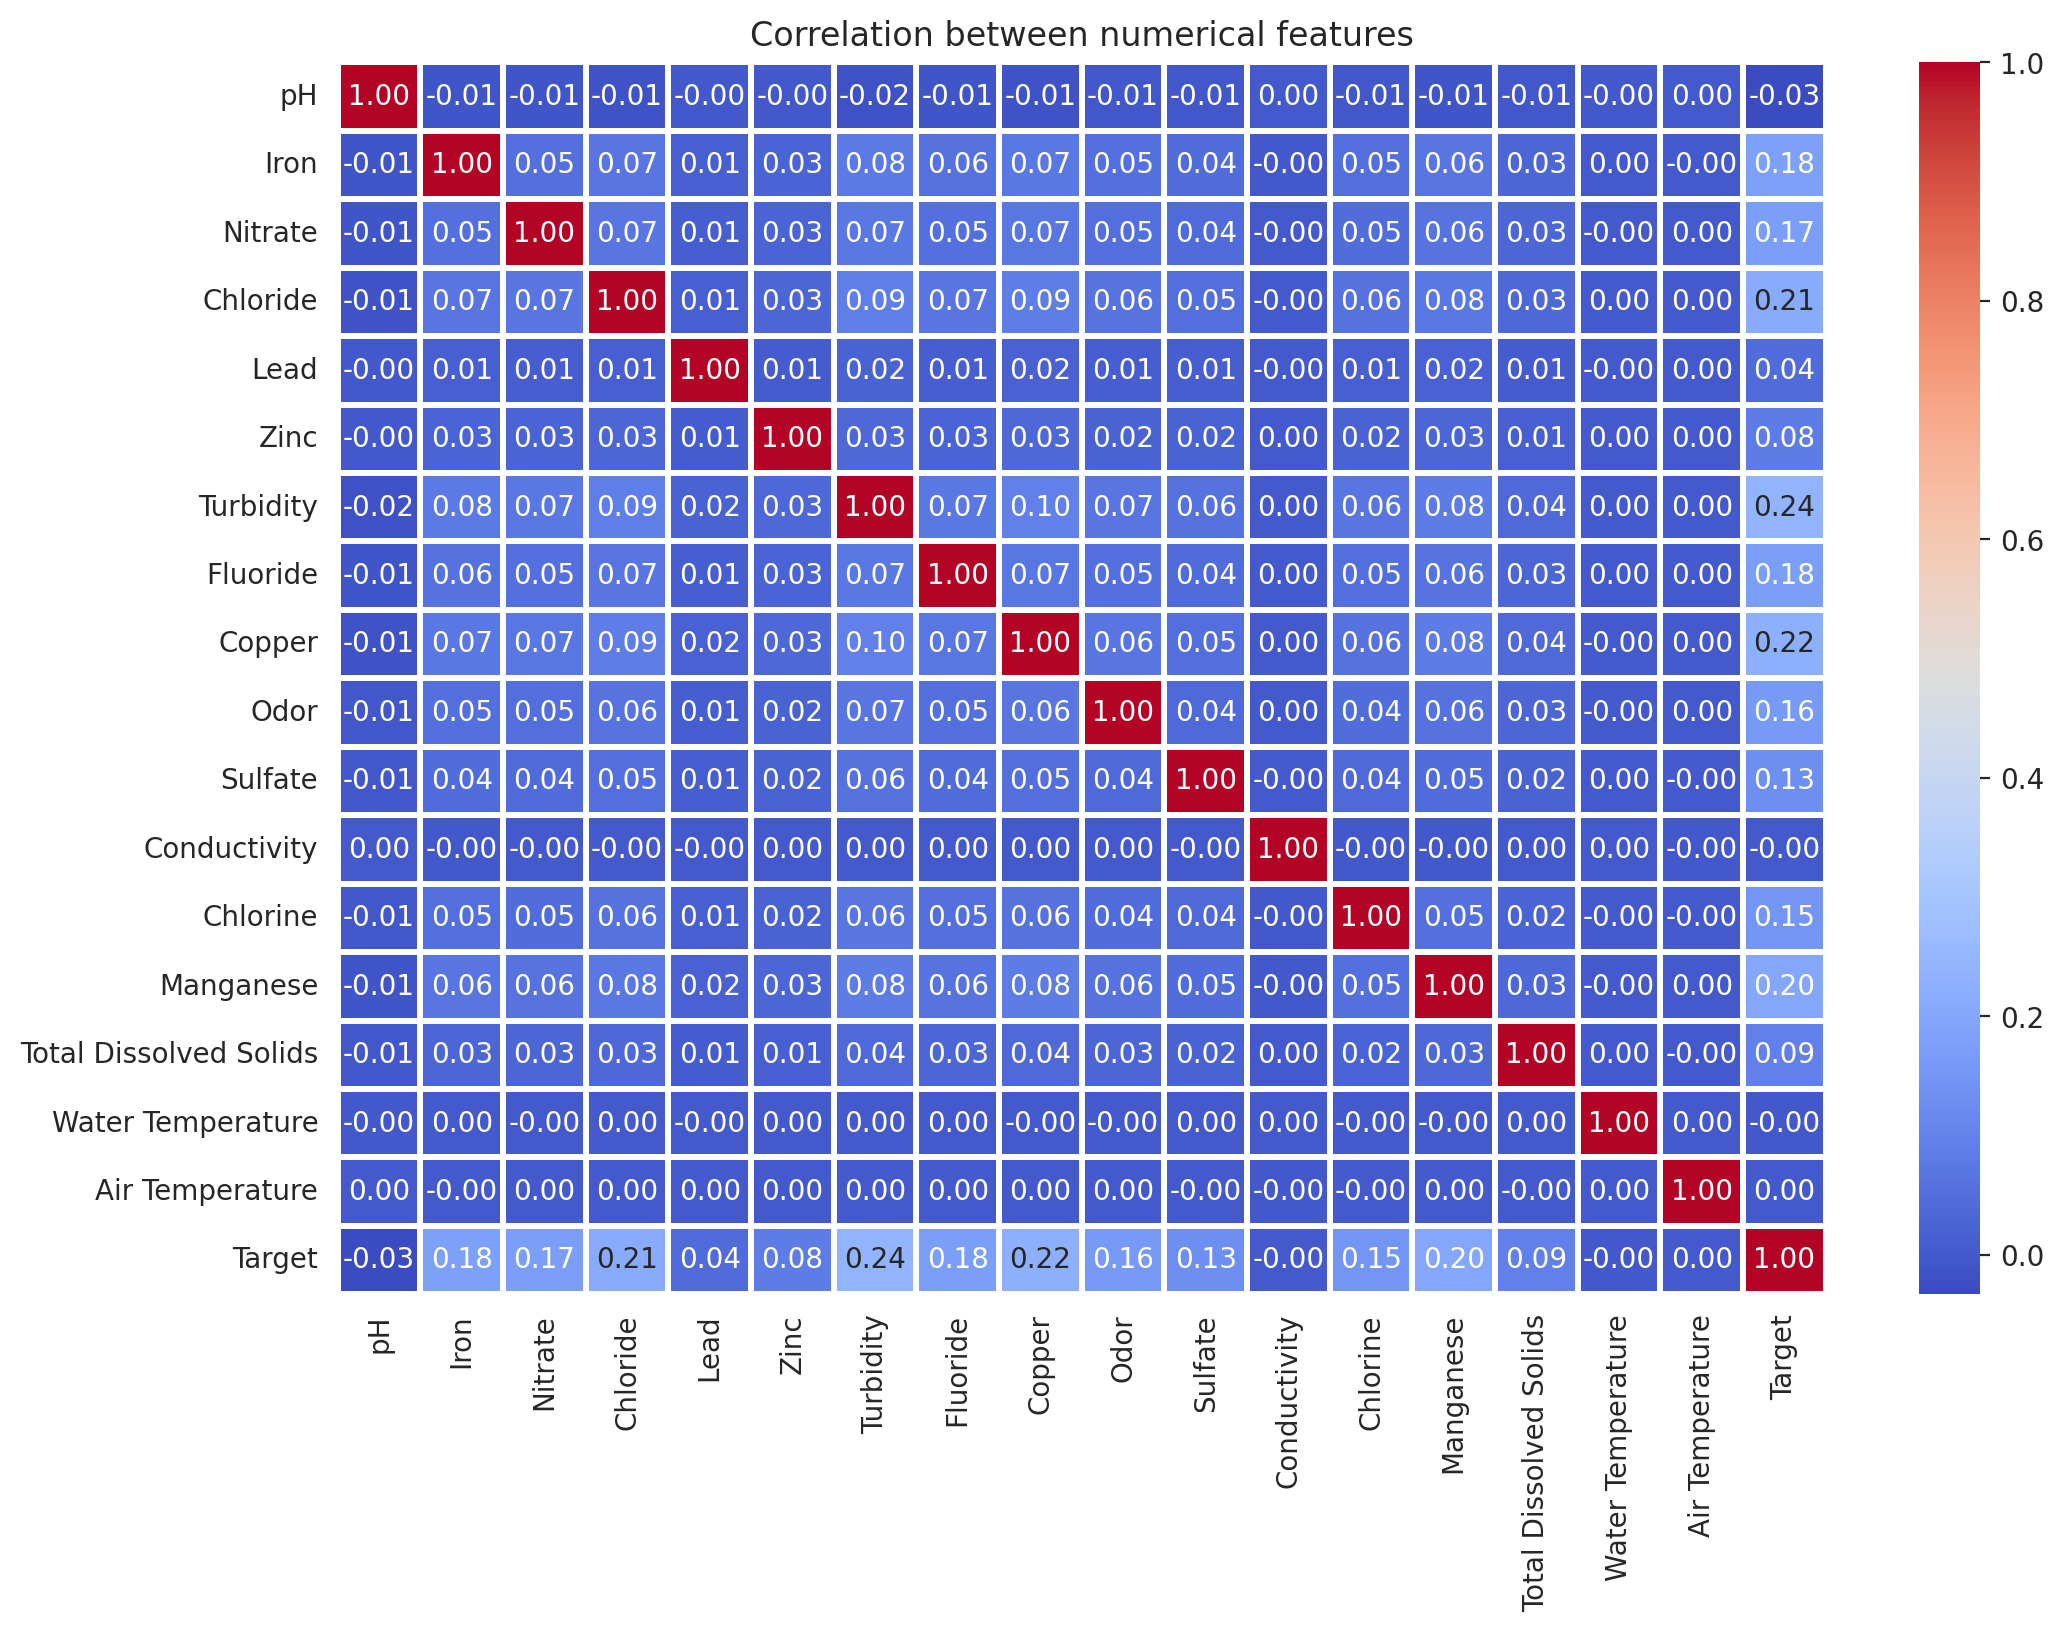

In [ ]:
# Create a heatmap to visualize the correlation between the numerical features
plt.figure(figsize=(12,8))
sns.heatmap(waterdf[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation between numerical features')
plt.savefig(f'{path}/plots/plot_correlation.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

Como se puede ver en el heatmap, no existe correlación entre las diferentes variables numéricas del dataset.

## Limpieza de los datos

In [ ]:
# Comprobación de missing values
waterdf.isnull().sum()

pH                        20231
Iron                       6991
Nitrate                   18695
Chloride                  30834
Lead                       4684
Zinc                      27675
Color                       981
Turbidity                  8694
Fluoride                  33218
Copper                    34882
Odor                      31332
Sulfate                   34525
Conductivity              28803
Chlorine                  10162
Manganese                 19339
Total Dissolved Solids      298
Source                    15535
Water Temperature         29688
Air Temperature            5303
Target                        0
dtype: int64

Existen valores pérdidos en todas las variables excepto en Target. Vamos a comprobar el porcentaje de valores perdidos para cada una de las características.

In [ ]:
# Check the percentage of missing values in each column
p_missing = waterdf.isnull().mean()*100
print(p_missing)

pH                        1.929380
Iron                      0.666714
Nitrate                   1.782896
Chloride                  2.940562
Lead                      0.446701
Zinc                      2.639296
Color                     0.093556
Turbidity                 0.829125
Fluoride                  3.167918
Copper                    3.326610
Odor                      2.988055
Sulfate                   3.292564
Conductivity              2.746871
Chlorine                  0.969125
Manganese                 1.844313
Total Dissolved Solids    0.028420
Source                    1.481534
Water Temperature         2.831271
Air Temperature           0.505734
Target                    0.000000
dtype: float64


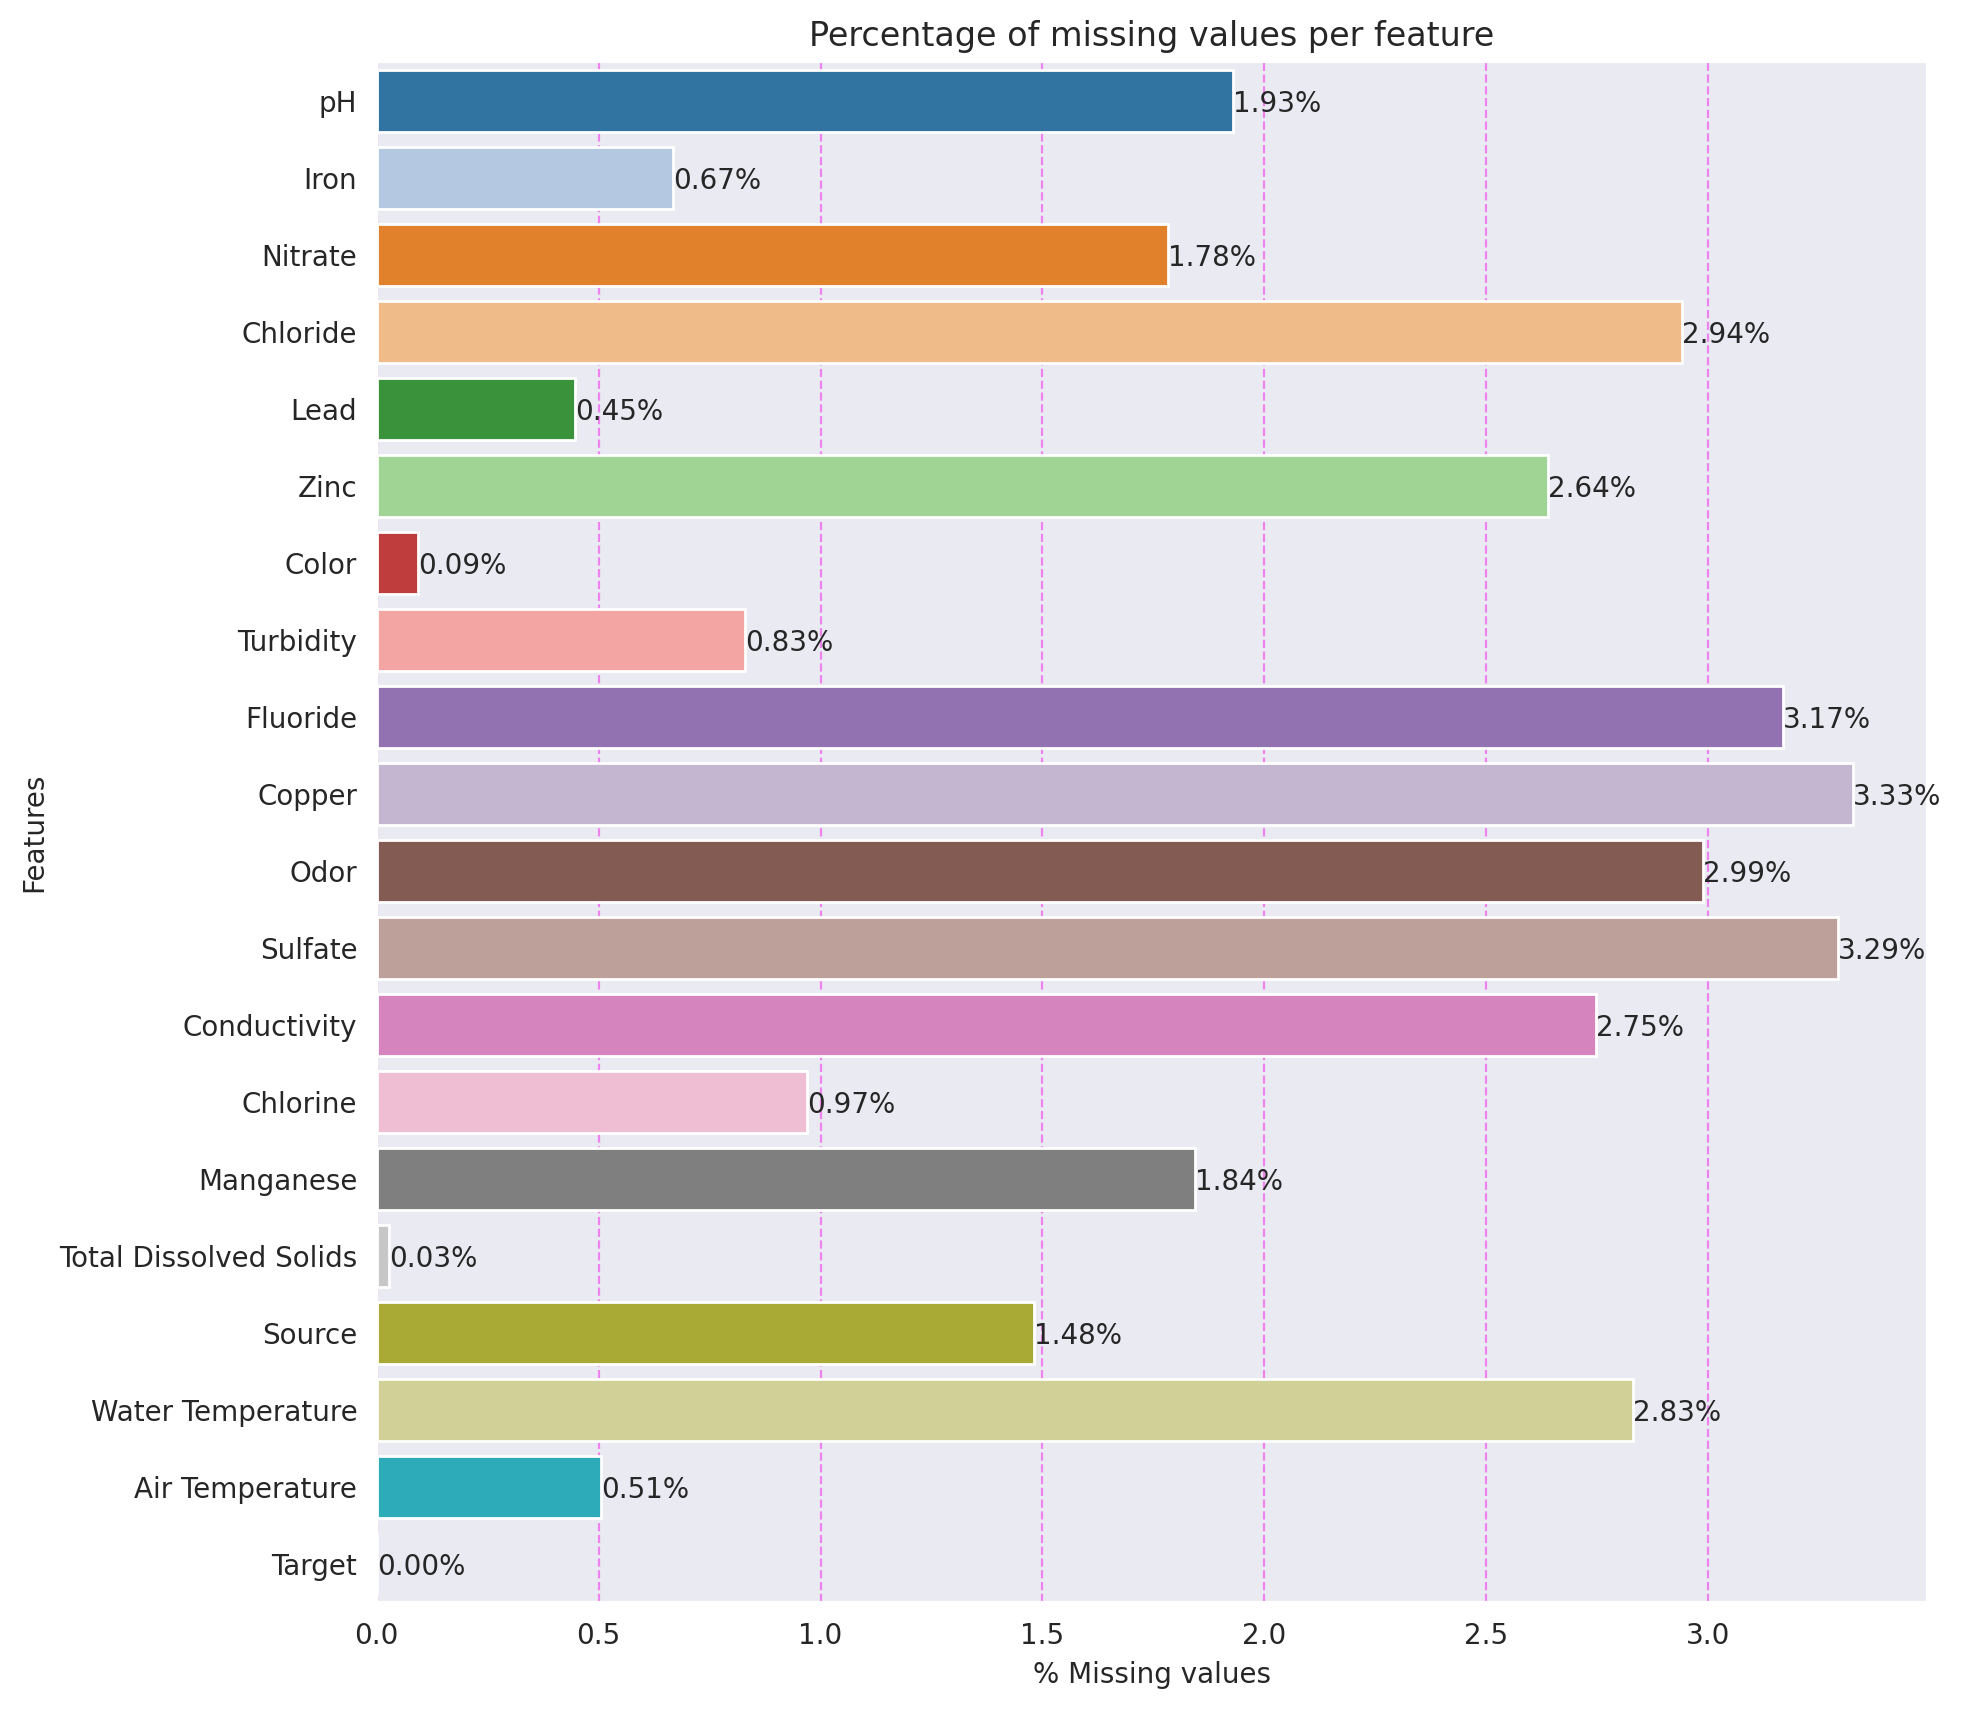

In [ ]:
# Create a bar plot with the frequency of the categories
plt.figure(figsize=(10,10))

# Create a bar plot with the percentage of missing values
graph = sns.barplot(x=p_missing, y=p_missing.index, palette='tab20', hue=p_missing.index)
plt.ylabel('Features')
plt.xlabel('% Missing values')
# Plot the frequency on top of the bars
for p in graph.patches:
    plt.text(p.get_width(), p.get_y() + 0.55*p.get_height(),'{:.2f}%'.format(p.get_width()), ha='left', va='center')

plt.title('Percentage of missing values per feature')
plt.xticks(rotation=0)

# Save the plot to a file
plt.savefig(f'{path}/plots/plot_missing_values.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

Los porcentajes de valores perdidos son bajos para cada una de las variables y contamos con un alto número de muestras, por lo que en principio podríamos prescindir de esas muestras. No obstante, hay que comprobar si esos valores pérdidos afectan a las mismas muestras o a diferentes.

<Axes: >

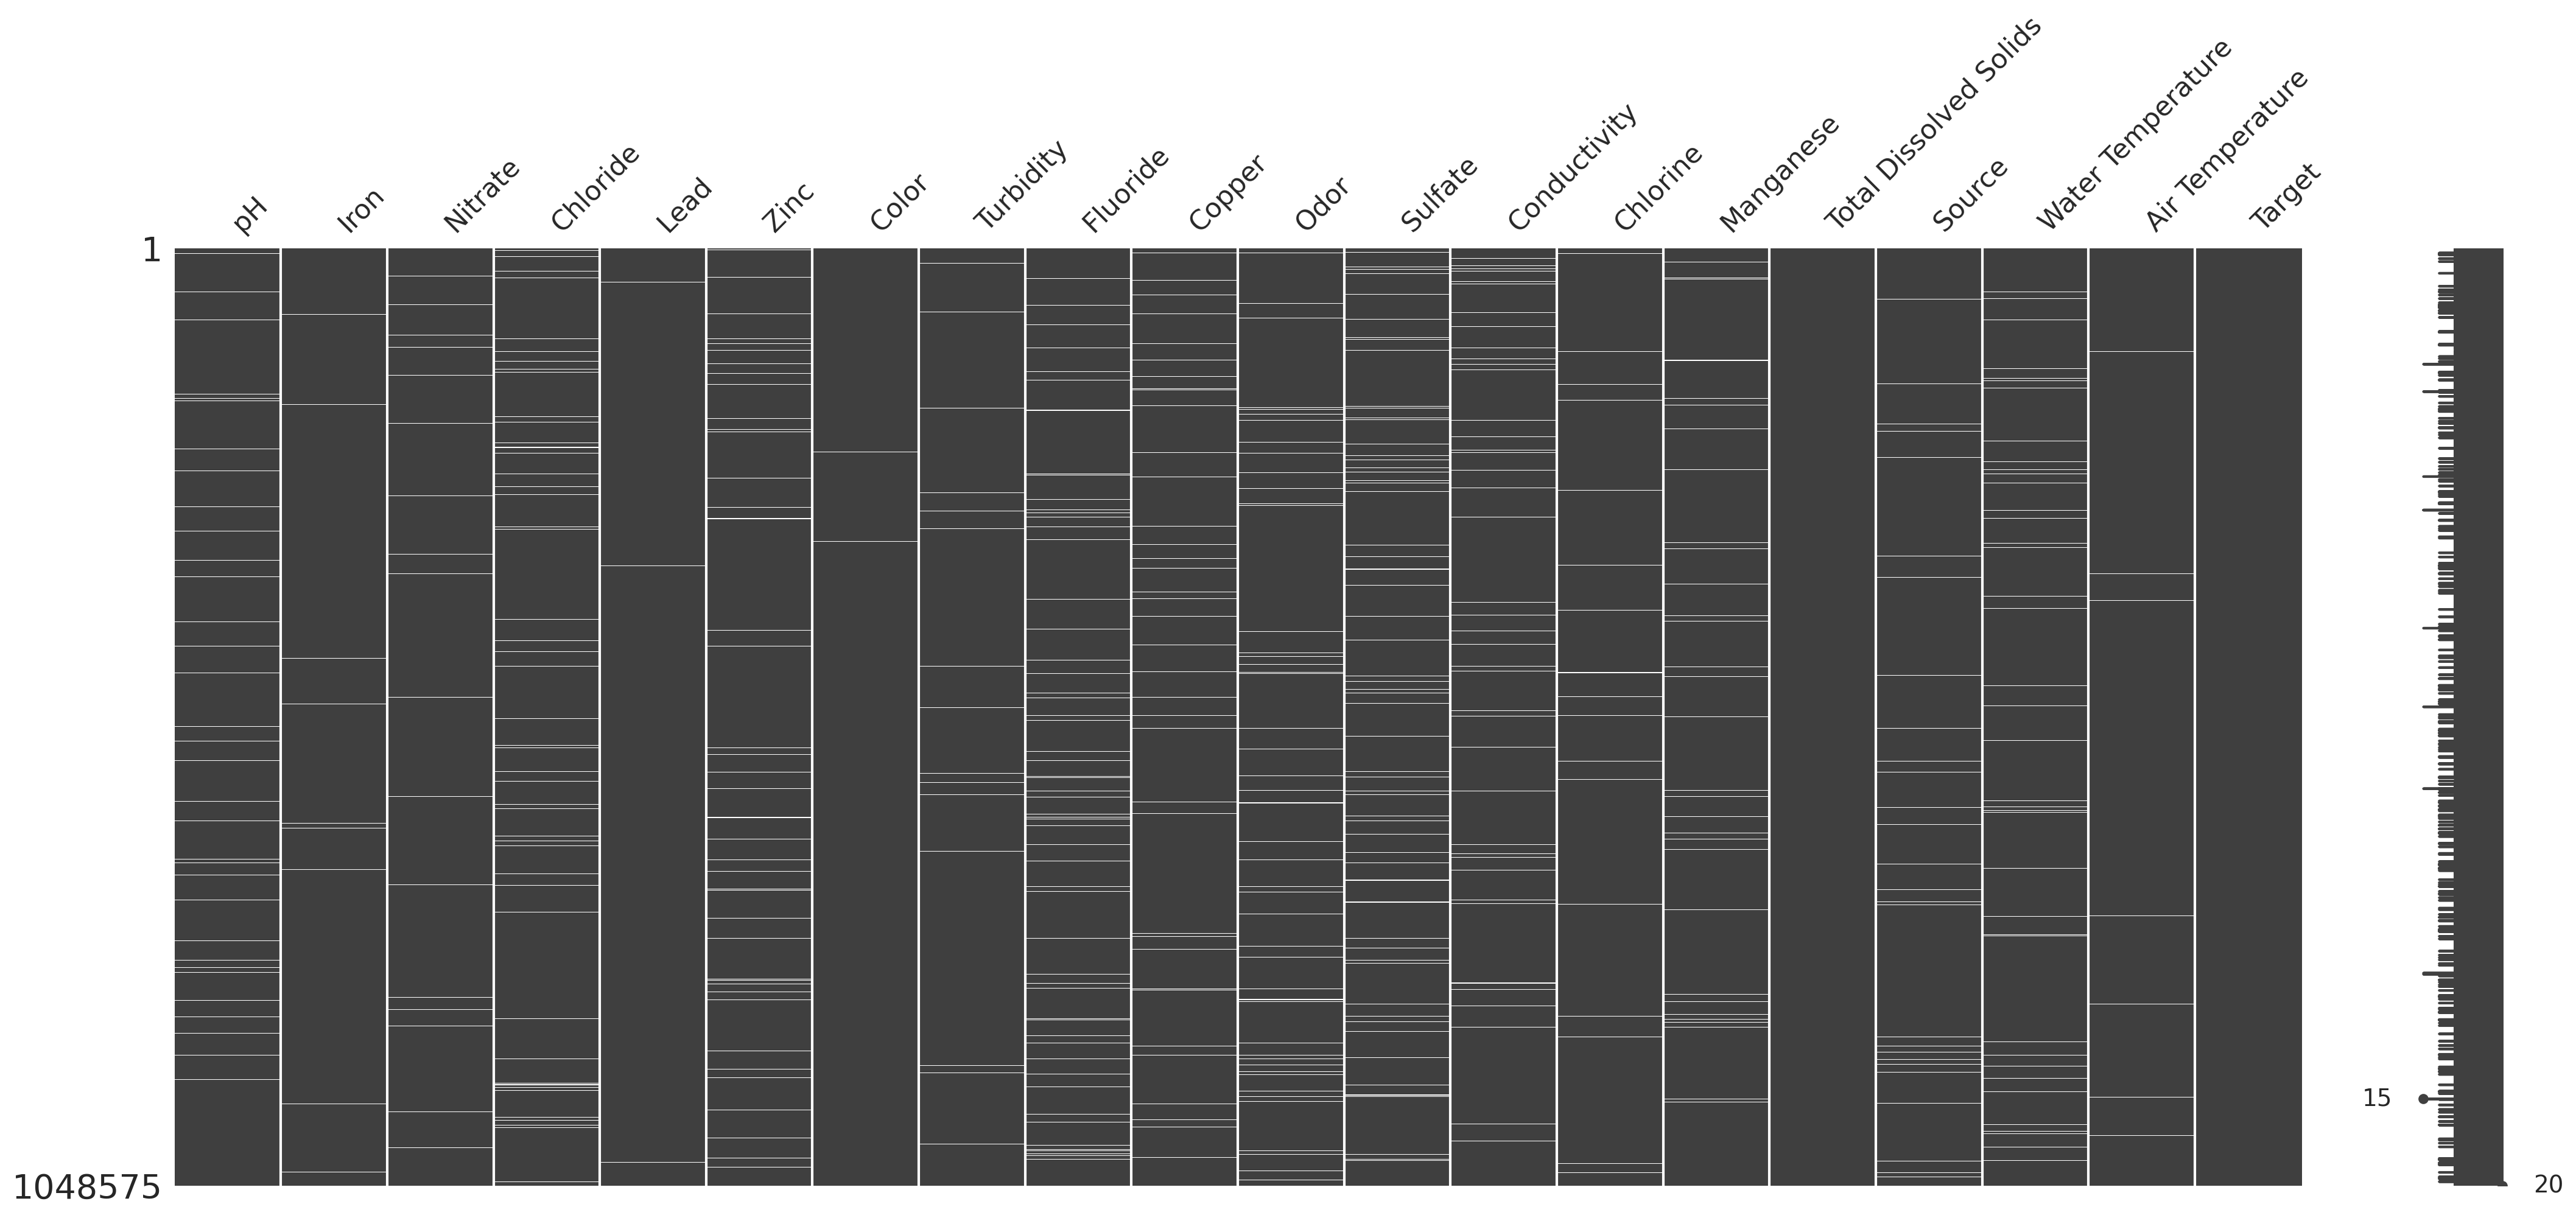

In [ ]:
msno.matrix(waterdf)

In [ ]:
# Check how many samples have any missing value
missing_samples = waterdf.isnull().any(axis=1).sum()
print(f'There are {missing_samples} samples with missing values')

# Check the percentage of samples with missing values
p_missing_samples = missing_samples / waterdf.shape[0] * 100
print(f'The percentage of samples with missing values is {p_missing_samples:.2f}%')

# Calculate the number of samples without any missing value
no_missing_samples = waterdf.dropna().shape[0]
print(f'There are {no_missing_samples} samples without missing values')

There are 309427 samples with missing values
The percentage of samples with missing values is 29.51%
There are 739148 samples without missing values


El 29.51% de las muestras tiene algún valor perdido. Si eliminasemos esas muestras nos quedaríamos con un total de 739.148 muestras. Este número es suficiente para realizar la tarea de clasificación por lo que de momento prescindiremos de las muestras con algún valor perdido.

In [ ]:
# Drop the samples with any missing value
df = waterdf.dropna()

In [ ]:
# Check the shape of the new dataframe
print(df.shape)

(739148, 20)


El dataframe resultante tiene 739148 muestras y 20 variables. Comprobamos ahora si hay muestras duplicadas, es decir, que tienen los mismos valores en TODAS las variables del dataframe.

In [ ]:
# Check the duplicated samples
duplicates = df.duplicated().sum()

print(f'There are {duplicates} duplicated samples')

# Check the percentage of duplicated samples
p_duplicates = duplicates / df.shape[0] * 100
print(f'The percentage of duplicated samples is {p_duplicates:.2f}%')

# Drop the duplicated samples
df = df.drop_duplicates()
print(df.shape)


There are 16232 duplicated samples
The percentage of duplicated samples is 2.20%
(722916, 20)


Tenemos 16232 muestras duplicadas, que suponen un 2,20% del total de muestras. Al eliminarlas nos quedamos con un total de 722.916 muestras, que siguen siendo suficientes. A partir de aquí, tras eliminar muestras con valores faltantes y duplicados, podríamos proceder a la separación de los conjuntos X e Y, así como la división de muestras en entrenamiento y test.

No obstante, dado que es un cuaderno para aprender, vamos a imputar los valores faltantes en lugar de eliminarlos. Para ello, vamos a utilizar la clase IterativeImputer de scikit-learn. Esta clase utiliza un modelo de regresión para predecir los valores faltantes en función de las otras características. También realizaremos el estandarizado de los datos para que todas las variables estén en la misma escala.

Para las variables categóricas utilizaremos el Simple Imputer con la estrategia "most_frequent".

Primero vamos a considerar los descriptivos para las muestras de agua potable y no potable:

In [ ]:
# Describe the numerical features when the target is 0
waterdf[waterdf['Target']==0].describe()

pH          Iron        Nitrate       Chloride  \
count  792171.000000  8.024810e+05  793418.000000  784037.000000   
mean        7.465185  7.069809e-02       5.782838     174.293907   
std         0.703682  3.096969e-01       2.647473      55.875668   
min         2.433522  2.050000e-53       0.286173      29.413497   
25%         6.974999  6.760000e-06       3.895896     135.452852   
50%         7.463071  1.550039e-03       5.444740     170.970729   
75%         7.962864  3.735280e-02       7.327294     208.676249   
max        12.322592  1.324129e+01      60.373341    1190.082896   

                Lead           Zinc     Turbidity       Fluoride  \
count   8.042720e+05  786539.000000  8.010670e+05  782263.000000   
mean    5.864554e-04       1.460667  3.715514e-01       0.865034   
std     1.900363e-02       1.365959  6.324082e-01       0.670036   
min     0.000000e+00       0.000001  1.410000e-14       0.000005   
25%    3.860000e-123       0.405850  3.259029e-02       0.358443   
50%     6.965000e-63       1.055228  1.749138e-01       0.734068   
75%     1.240000e-27       2.154933  5.094366e-01       1.247176   
max     2.872971e+00      24.072897  1.929611e+01      12.851710   

             Copper           Odor        Sulfate   Conductivity  \
count  7.810000e+05  783664.000000  781072.000000  785553.000000   
mean   4.244250e-01       1.679067     139.806499     424.886924   
std    4.454790e-01       0.984694      59.036394     189.836848   
min    2.100000e-09       0.011001      11.940727      14.188297   
25%    1.182109e-01       0.835839      96.506843     286.316040   
50%    3.146555e-01       1.663613     132.017761     397.109382   
75%    6.181717e-01       2.489071     175.968891     533.510226   
max    1.118297e+01       4.141952    1279.553774    1891.515730   

            Chlorine     Manganese  Total Dissolved Solids  Water Temperature  \
count  799980.000000  7.929260e+05           807616.000000      785015.000000   
mean        3.178594  4.569202e-02              257.020851          19.161493   
std         0.648339  2.993965e-01              149.216010          11.385399   
min         0.999411  4.070000e-46                0.010643           0.666194   
25%         2.718891  1.180000e-06              128.325912          11.365169   
50%         3.167916  3.039215e-04              256.439352          16.472967   
75%         3.627753  7.745099e-03              384.147239          23.880499   
max         9.776151  1.507660e+01              579.797750         243.005083   

       Air Temperature    Target  
count    803725.000000  807841.0  
mean         60.007485       0.0  
std          18.074502       0.0  
min         -32.010327       0.0  
25%          47.830849       0.0  
50%          59.982212       0.0  
75%          72.223080       0.0  
max         140.875607       0.0

In [ ]:
# Describe the numerical features when the target is 1
waterdf[waterdf['Target']==1].describe()

pH          Iron        Nitrate       Chloride  \
count  236173.000000  2.391030e+05  236462.000000  233704.000000   
mean        7.398498  2.591762e-01       7.070922     207.269070   
std         1.210647  7.119439e-01       4.233664      86.740794   
min         2.058008  9.700000e-41       0.453584      32.203769   
25%         6.572056  2.530000e-05       4.173689     145.586864   
50%         7.396368  5.783678e-03       6.071571     191.354201   
75%         8.220332  1.442470e-01       8.816747     251.084821   
max        12.891960  1.574860e+01      73.072931    1430.548852   

                Lead          Zinc     Turbidity       Fluoride        Copper  \
count   2.396190e+05  2.343610e+05  2.388140e+05  233094.000000  2.326930e+05   
mean    3.658545e-03  1.758020e+00  8.594137e-01       1.196003  7.272755e-01   
std     5.273098e-02  1.882106e+00  1.306385e+00       1.069899  8.124326e-01   
min     0.000000e+00  6.350000e-07  2.470000e-13       0.000025  6.260000e-07   
25%    1.190000e-121  4.367644e-01  6.054091e-02       0.419577  1.613472e-01   
50%     2.040000e-61  1.146206e+00  3.342623e-01       0.897497  4.538915e-01   
75%     4.375000e-26  2.437200e+00  1.115369e+00       1.651852  1.011103e+00   
max     3.503948e+00  2.836867e+01  1.859262e+01      12.486697  1.139056e+01   

                Odor        Sulfate   Conductivity       Chlorine  \
count  233579.000000  232978.000000  234219.000000  238433.000000   
mean        2.087227     160.674560     424.672043       3.432868   
std         1.196668      85.770138     189.485389       0.875696   
min         0.011007      18.385899      13.054824       1.035579   
25%         1.049167     100.919021     286.359372       2.807602   
50%         2.087841     141.674322     396.612277       3.324866   
75%         3.131901     198.693451     532.749474       3.942072   
max         4.141991    1393.433430    1854.745885      10.688417   

          Manganese  Total Dissolved Solids  Water Temperature  \
count  2.363100e+05           240661.000000      233872.000000   
mean   2.540403e-01              290.849832          19.127107   
std    7.144349e-01              167.925193          11.360216   
min    1.380000e-46                0.020555           1.541784   
25%    1.960000e-05              145.125214          11.345798   
50%    5.146790e-03              290.989269          16.443993   
75%    1.374211e-01              436.399185          23.810559   
max    2.374086e+01              579.799458         187.747872   

       Air Temperature    Target  
count    239547.000000  240734.0  
mean         60.116486       1.0  
std          18.115505       0.0  
min         -33.870915       1.0  
25%          47.880737       1.0  
50%          60.154740       1.0  
75%          72.277092       1.0  
max         144.078518       1.0

Como hay variables que sí difieren bastante, es mejor utilizar la Imputación multivariante, que modela cada variable con valores faltantes utilizando los valores del resto de variables. No obstante, primero hay que imputar las variables categóricas y después transformar estas variables a numéricas.

## Preprocesado

Las variables categóricas se pueden codificar como hot encoding o label encoding. Para las variables dicotómicas es mejor utilizar el hot-encoding ya que no supone un aumento de la dimensionalidad, mientras que para las variables con muchas categorías es mejor emplear otra técnica para evitar la alta dimensionalidad.

In [ ]:
# Describe the categorical features when the target is 0
waterdf[waterdf['Target']==0].describe(include=['category'])

Color   Source
count           807071   795838
unique               5        8
top     Near Colorless  Aquifer
freq            279007   100196

In [ ]:
# Describe the categorical features when the target is 1
waterdf[waterdf['Target']==1].describe(include=['category'])

Color  Source
count   240523  237202
unique       5       8
top     Yellow  Ground
freq     49572   29928

In [ ]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
# Get the categorical columns
categorical_columns = waterdf.select_dtypes(include=['object', 'category']).columns
# Apply the imputer to the categorical columns
waterdf[categorical_columns] = categorical_imputer.fit_transform(waterdf[categorical_columns])

# Check the missing values
waterdf.isnull().sum()

pH                        20231
Iron                       6991
Nitrate                   18695
Chloride                  30834
Lead                       4684
Zinc                      27675
Color                         0
Turbidity                  8694
Fluoride                  33218
Copper                    34882
Odor                      31332
Sulfate                   34525
Conductivity              28803
Chlorine                  10162
Manganese                 19339
Total Dissolved Solids      298
Source                        0
Water Temperature         29688
Air Temperature            5303
Target                        0
dtype: int64

In [ ]:
# Check the duplicates and drop them
duplicates = waterdf.duplicated().sum()
print(f'There are {duplicates} duplicated samples')
waterdf = waterdf.drop_duplicates()

There are 16433 duplicated samples


In [ ]:
# Get the unique values of the variable 'Color'
waterdf['Color'].unique()

array(['Colorless', 'Faint Yellow', 'Light Yellow', 'Near Colorless',
       'Yellow'], dtype=object)

In [ ]:
# Transform the categorical features to numerical using one-hot encoding for the variable Source, and label encoding for the variable 'Color'
color_cat = ['Colorless', 'Near Colorless', 'Faint Yellow', 'Light Yellow', 'Yellow']

ord_enc = OrdinalEncoder(categories=[color_cat])

waterdf['Color'] = ord_enc.fit_transform(waterdf['Color'].values.reshape(-1,1))

# Check the unique values of the variable 'Color'
print(waterdf['Color'].unique())


[0. 2. 3. 1. 4.]


In [ ]:
# Apply one-hot encoding to the variable 'Source' using the get_dummies function
waterdf = pd.get_dummies(waterdf, columns=['Source'], drop_first=True, prefix='Source', prefix_sep='_', dtype='int')

# Check the new columns
print(waterdf.columns)

Index(['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Color',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Water Temperature',
       'Air Temperature', 'Target', 'Source_Ground', 'Source_Lake',
       'Source_Reservoir', 'Source_River', 'Source_Spring', 'Source_Stream',
       'Source_Well'],
      dtype='object')


In [ ]:
waterdf.head()

pH      Iron   Nitrate    Chloride           Lead      Zinc  Color  \
0  8.332988  0.000083  8.605777  122.799772   3.710000e-52  3.434827    0.0   
1  6.917863  0.000081  3.734167  227.029851   7.850000e-94  1.245317    2.0   
2  5.443762  0.020106  3.816994  230.995630   5.290000e-76  0.528280    3.0   
3  7.955339  0.143988  8.224944  178.129940  4.000000e-176  4.027879    1.0   
4  8.091909  0.002167  9.925788  186.540872  4.170000e-132  3.807511    3.0   

   Turbidity  Fluoride    Copper  ...  Water Temperature  Air Temperature  \
0   0.022683  0.607283  0.144599  ...                NaN        43.493324   
1   0.019007  0.622874  0.437835  ...          15.348981        71.220586   
2   0.319956  0.423423  0.431588  ...          11.643467        44.891330   
3   0.166319  0.208454  0.239451  ...          10.092392        60.843233   
4   0.004867  0.222912  0.616574  ...          15.249416        69.336671   

   Target  Source_Ground  Source_Lake  Source_Reservoir  Source_River  \
0       0              0            0                 0             0   
1       0              0            1                 0             0   
2       0              0            0                 0             1   
3       0              1            0                 0             0   
4       0              0            0                 0             0   

   Source_Spring  Source_Stream  Source_Well  
0              0              0            1  
1              0              0            0  
2              0              0            0  
3              0              0            0  
4              1              0            0  

[5 rows x 26 columns]

In [ ]:
imputer = IterativeImputer()

X = pd.DataFrame(imputer.fit_transform(waterdf))

X.columns = waterdf.columns

X.head()

pH      Iron   Nitrate    Chloride           Lead      Zinc  Color  \
0  8.332988  0.000083  8.605777  122.799772   3.710000e-52  3.434827    0.0   
1  6.917863  0.000081  3.734167  227.029851   7.850000e-94  1.245317    2.0   
2  5.443762  0.020106  3.816994  230.995630   5.290000e-76  0.528280    3.0   
3  7.955339  0.143988  8.224944  178.129940  4.000000e-176  4.027879    1.0   
4  8.091909  0.002167  9.925788  186.540872  4.170000e-132  3.807511    3.0   

   Turbidity  Fluoride    Copper  ...  Water Temperature  Air Temperature  \
0   0.022683  0.607283  0.144599  ...          19.131581        43.493324   
1   0.019007  0.622874  0.437835  ...          15.348981        71.220586   
2   0.319956  0.423423  0.431588  ...          11.643467        44.891330   
3   0.166319  0.208454  0.239451  ...          10.092392        60.843233   
4   0.004867  0.222912  0.616574  ...          15.249416        69.336671   

   Target  Source_Ground  Source_Lake  Source_Reservoir  Source_River  \
0     0.0            0.0          0.0               0.0           0.0   
1     0.0            0.0          1.0               0.0           0.0   
2     0.0            0.0          0.0               0.0           1.0   
3     0.0            1.0          0.0               0.0           0.0   
4     0.0            0.0          0.0               0.0           0.0   

   Source_Spring  Source_Stream  Source_Well  
0            0.0            0.0          1.0  
1            0.0            0.0          0.0  
2            0.0            0.0          0.0  
3            0.0            0.0          0.0  
4            1.0            0.0          0.0  

[5 rows x 26 columns]

Vamos a separar ahora la variable respuesta (Target) en y y las variables predictoras o características en X.

In [ ]:
y = X['Target']

X = X.drop(columns=['Target'])

In [ ]:
print(X.shape)
print(y.shape)

(1032142, 25)
(1032142,)


In [ ]:
X.describe()

pH          Iron       Nitrate      Chloride           Lead  \
count  1.032142e+06  1.032142e+06  1.032142e+06  1.032142e+06   1.032142e+06   
mean   7.449977e+00  1.135706e-01  6.076326e+00  1.817919e+02   1.279470e-03   
std    8.384766e-01  4.410067e-01  3.101124e+00  6.474161e+01   2.988756e-02   
min    2.058008e+00 -9.544880e-03  2.861727e-01  2.941350e+01  -5.931004e-04   
25%    6.926728e+00  9.420000e-06  3.983313e+00  1.386295e+02  1.720000e-122   
50%    7.457296e+00  2.162305e-03  5.609543e+00  1.747507e+02   3.530000e-62   
75%    7.989268e+00  5.150783e-02  7.540612e+00  2.143244e+02   6.530000e-27   
max    1.289196e+01  1.574860e+01  7.307293e+01  1.430549e+03   3.503948e+00   

               Zinc         Color     Turbidity      Fluoride        Copper  \
count  1.032142e+06  1.032142e+06  1.032142e+06  1.032142e+06  1.032142e+06   
mean   1.528485e+00  1.341357e+00  4.825110e-01  9.402148e-01  4.932896e-01   
std    1.484207e+00  1.248834e+00  8.562766e-01  7.790996e-01  5.559535e-01   
min    6.350000e-07  0.000000e+00  1.410000e-14  4.550000e-06  2.100000e-09   
25%    4.273762e-01  0.000000e+00  3.764456e-02  3.821928e-01  1.319754e-01   
50%    1.121007e+00  1.000000e+00  2.036016e-01  7.923052e-01  3.558668e-01   
75%    2.169501e+00  2.000000e+00  5.917826e-01  1.296771e+00  6.740697e-01   
max    2.836867e+01  4.000000e+00  1.929611e+01  1.285171e+01  1.139056e+01   

       ...  Total Dissolved Solids  Water Temperature  Air Temperature  \
count  ...            1.032142e+06       1.032142e+06     1.032142e+06   
mean   ...            2.647393e+02       1.915281e+01     6.003205e+01   
std    ...            1.543106e+02       1.121211e+01     1.803665e+01   
min    ...            1.064299e-02       6.661938e-01    -3.387091e+01   
25%    ...            1.318232e+02       1.150882e+01     4.791475e+01   
50%    ...            2.635394e+02       1.680107e+01     6.003142e+01   
75%    ...            3.948609e+02       2.356815e+01     7.216490e+01   
max    ...            5.797995e+02       2.430051e+02     1.440785e+02   

       Source_Ground   Source_Lake  Source_Reservoir  Source_River  \
count   1.032142e+06  1.032142e+06      1.032142e+06  1.032142e+06   
mean    1.233764e-01  1.226343e-01      1.225926e-01  1.229879e-01   
std     3.288690e-01  3.280171e-01      3.279692e-01  3.284235e-01   
min     0.000000e+00  0.000000e+00      0.000000e+00  0.000000e+00   
25%     0.000000e+00  0.000000e+00      0.000000e+00  0.000000e+00   
50%     0.000000e+00  0.000000e+00      0.000000e+00  0.000000e+00   
75%     0.000000e+00  0.000000e+00      0.000000e+00  0.000000e+00   
max     1.000000e+00  1.000000e+00      1.000000e+00  1.000000e+00   

       Source_Spring  Source_Stream   Source_Well  
count   1.032142e+06   1.032142e+06  1.032142e+06  
mean    1.226595e-01   1.235906e-01  1.385914e-01  
std     3.280461e-01   3.291140e-01  3.455198e-01  
min     0.000000e+00   0.000000e+00  0.000000e+00  
25%     0.000000e+00   0.000000e+00  0.000000e+00  
50%     0.000000e+00   0.000000e+00  0.000000e+00  
75%     0.000000e+00   0.000000e+00  0.000000e+00  
max     1.000000e+00   1.000000e+00  1.000000e+00  

[8 rows x 25 columns]

A continuación estandarizamos las variables para que todas estén en la misma escala y sean homogéneas.

In [ ]:
# Standardize the features
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X.describe()

pH          Iron       Nitrate      Chloride          Lead  \
count  1.032142e+06  1.032142e+06  1.032142e+06  1.032142e+06  1.032142e+06   
mean   1.924755e-15  8.976940e-17  2.938709e-16 -6.453484e-16 -1.073928e-18   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -6.430676e+00 -2.791694e-01 -1.867115e+00 -2.353641e+00 -6.265386e-02   
25%   -6.240481e-01 -2.575047e-01 -6.749212e-01 -6.666870e-01 -4.280946e-02   
50%    8.729481e-03 -2.526229e-01 -1.505206e-01 -1.087582e-01 -4.280946e-02   
75%    6.431798e-01 -1.407299e-01  4.721791e-01  5.024979e-01 -4.280946e-02   
max    6.490326e+00  3.545307e+01  2.160398e+01  1.928833e+01  1.171949e+02   

               Zinc         Color     Turbidity      Fluoride        Copper  \
count  1.032142e+06  1.032142e+06  1.032142e+06  1.032142e+06  1.032142e+06   
mean  -1.018855e-16 -2.004666e-17 -4.714271e-17  6.441368e-16  5.925882e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.029833e+00 -1.074088e+00 -5.634992e-01 -1.206791e+00 -8.872862e-01   
25%   -7.418841e-01 -1.074088e+00 -5.195361e-01 -7.162400e-01 -6.499005e-01   
50%   -2.745427e-01 -2.733408e-01 -3.257236e-01 -1.898470e-01 -2.471842e-01   
75%    4.318916e-01  5.274065e-01  1.276126e-01  4.576518e-01  3.251714e-01   
max    1.808386e+01  2.128901e+00  2.197142e+01  1.528880e+01  1.960105e+01   

       ...  Total Dissolved Solids  Water Temperature  Air Temperature  \
count  ...            1.032142e+06       1.032142e+06     1.032142e+06   
mean   ...            2.514645e-16      -6.754735e-16     5.310576e-16   
std    ...            1.000000e+00       1.000000e+00     1.000000e+00   
min    ...           -1.715558e+00      -1.648808e+00    -5.206234e+00   
25%    ...           -8.613547e-01      -6.817621e-01    -6.718158e-01   
50%    ...           -7.775727e-03      -2.097499e-01    -3.512429e-05   
75%    ...            8.432446e-01       3.938011e-01     6.726779e-01   
max    ...            2.041728e+00       1.996522e+01     4.659763e+00   

       Source_Ground   Source_Lake  Source_Reservoir  Source_River  \
count   1.032142e+06  1.032142e+06      1.032142e+06  1.032142e+06   
mean    4.510500e-17 -2.423223e-18     -6.074580e-17 -6.237046e-18   
std     1.000000e+00  1.000000e+00      1.000000e+00  1.000000e+00   
min    -3.751540e-01 -3.738657e-01     -3.737933e-01 -3.744798e-01   
25%    -3.751540e-01 -3.738657e-01     -3.737933e-01 -3.744798e-01   
50%    -3.751540e-01 -3.738657e-01     -3.737933e-01 -3.744798e-01   
75%    -3.751540e-01 -3.738657e-01     -3.737933e-01 -3.744798e-01   
max     2.665572e+00  2.674757e+00      2.675275e+00  2.670371e+00   

       Source_Spring  Source_Stream   Source_Well  
count   1.032142e+06   1.032142e+06  1.032142e+06  
mean    2.820439e-17  -4.001072e-17 -7.434889e-19  
std     1.000000e+00   1.000000e+00  1.000000e+00  
min    -3.739095e-01  -3.755252e-01 -4.011100e-01  
25%    -3.739095e-01  -3.755252e-01 -4.011100e-01  
50%    -3.739095e-01  -3.755252e-01 -4.011100e-01  
75%    -3.739095e-01  -3.755252e-01 -4.011100e-01  
max     2.674444e+00   2.662937e+00  2.493081e+00  

[8 rows x 25 columns]

Ahora ya tenemos el dataset bien procesado y sin valores faltantes. El paso siguiente será realizar la división de las muestras en los conjuntos de entrenamiento y test.

## División de muestras

Dividimos ahora las muestras en los conjuntos de entrenamiento y test. Utilizamos un valor en random_state para que se pueda reproducir la división y ademmás aplicamos la estratificación en función de la etiqueta para que la distribución de las muestras sea igual en el entrenamiento y en el test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Save the train and test datasets to use the same during the modeling phase
X_train.to_csv(f'{path}/X_train.csv', index=False)
X_test.to_csv(f'{path}/X_test.csv', index=False)
y_train.to_csv(f'{path}/y_train.csv', index=False)
y_test.to_csv(f'{path}/y_test.csv', index=False)

Los datasets se están guardando en Google drive para poder recuperarlos en otras sesiones.

In [ ]:
# Read the train and test datasets
X_train = pd.read_csv(f'{path}/X_train.csv')
X_test = pd.read_csv(f'{path}/X_test.csv')
y_train = pd.read_csv(f'{path}/y_train.csv')
y_test = pd.read_csv(f'{path}/y_test.csv')

In [ ]:
# Change y to a 1D array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [ ]:
# Check the shape of the datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(825713, 25)
(206429, 25)
(825713,)
(206429,)


## Modelos de clasificación

En este apartado vamos a comparar diferentes modelos utilizando métricas de evaluación de rendimiento para elegir el modelo que mejor funciona. En primer lugar utilizaremos GridSearchCV para ajustar cada uno de los modelos y obtener los mejores hiperparámetros. Los modelos que vamos a utilizar son Regresión Logística, Naive Bayes, KNN, Decision Tree y Random Forest.

Dado que las muestras están desbalanceadas y hay más muestras de agua potable que no potable, es mejor NO utilizar la métrica 'accuracy' (exactitud). En este caso es mejor utilizar AUC ROC ya que esta métrica mide la capacidad del modelo para distinguir entre clases y es especialmente útil en problemas de clasificación binaria.

In [ ]:
score = 'roc_auc'

param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.logspace(-3,3,7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

k_range = list(range(5, 20))

param_grid_knn = {
    'n_neighbors': k_range,
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': [1,0.1,0.01,0.001]
}

param_grid_dt = {
    'max_depth': [10, 20, 30, 40, 50],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [5, 10, 20, 50, 100]
}

param_grid_rf = {
    'max_depth': [10, 20, 30, 40, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [50, 100, 150, 200, 300],
    'criterion': ['gini', 'entropy']
}

k = 5
# Save the original standard output
original_stdout = sys.stdout

Vamos ahora con cada uno de los modelos. Podríamos crear un bucle, pero vamos a hacer uno por uno ya que hay muchas muestras que procesar y los tiempos pueden alargarse. Vamos a redirigir la salida a ficheros de texto para poder revisar luego los resultados mejor.

In [ ]:
# Create a folder to store the results
if not os.path.exists(f'{path}/Reports'):
    os.makedirs(f'{path}/Reports')

In [ ]:
# Dictionary with the model_name and the parameter grid
models = {
    'LR': (LogisticRegression(), param_grid_lr),
    'NB': (GaussianNB(), param_grid_nb),
    'KNN': (KNeighborsClassifier(), param_grid_knn),
    'SVM': (SVC(), param_grid_svm),
    'DT': (DecisionTreeClassifier(), param_grid_dt),
    'RF': (RandomForestClassifier(), param_grid_rf)
}

In [ ]:
# Dictionary to store the best models
best_models = {}

In [ ]:
def train_and_report(model_name, version, k, score):

    # Open a file for writing
    with open(f'{path}/Reports/{model_name}{version}.txt', 'w') as f:
        # Redirect standard output to the file
        with redirect_stdout(f):

            print(f'CLASSIFIER {model_name}:')
            print('================================================')
            # Get the model and the parameter grid
            model, param_grid = models[model_name]
            grid_search = GridSearchCV(model, param_grid, cv=k, scoring=score, verbose=7, n_jobs=-1)
            grid_search.fit(X_train, y_train)

            print('================================================')
            print('================================================')

            print(f'Best parameters: {grid_search.best_params_}')
            print(f'Best estimator: {grid_search.best_estimator_}')

            y_pred = grid_search.predict(X_test)
            print('================================================')
            print('================================================')
            print(confusion_matrix(y_test, y_pred, labels=[0, 1]))
            print()
            print(classification_report(y_test, y_pred))
            print('================================================')
            print('================================================')

    # Restore the original standard output
    sys.stdout = original_stdout
    print("TRAIN FINISHED")

    # Return the best estimator
    return grid_search.best_estimator_

In [ ]:
## Logistic Regression
best_models['LR'] = train_and_report('LR', '', k, score)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


280 fits failed out of a total of 525.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: So

TRAIN FINISHED


In [ ]:
## Naive Bayes
best_models['NB'] = train_and_report('NB', '', k, score)

TRAIN FINISHED


In [ ]:
## K-Nearest Neighbors
best_models['KNN'] = train_and_report('KNN', '', k, score)

In [ ]:
## Support Vector Machine
best_models['SVM'] = train_and_report('SVM', k, score)

In [ ]:
## Decision Tree
best_models['DT'] = train_and_report('DT', '', k, score)

TRAIN FINISHED


In [ ]:
## Random Forest
best_models['RF'] = train_and_report('RF', '', k, score)

In [ ]:
# Print the best models
print(best_models)

# Save the best models in a file. Append to the end of the file.
with open(f'{path}/Reports/best_models.txt', 'a') as f:
    # Redirect standard output to the file
    with redirect_stdout(f):
        print(best_models)

    # Restore the original standard output
    sys.stdout = original_stdout

{'LR': LogisticRegression(C=0.001, solver='liblinear'), 'NB': GaussianNB(var_smoothing=1.232846739442066e-08), 'DT': DecisionTreeClassifier(max_depth=20, min_samples_leaf=100)}


Los resultados obtenidos han sido:

*   LogisticRegression(C=0.001, solver='liblinear')
*   GaussianNB(var_smoothing=1.232846739442066e-08)
*   DecisionTreeClassifier(max_depth=20, min_samples_leaf=100)

Dado que estamos trabajando con tantas muestras, SVM, KNN y RF requieren mucho tiempo de computación (entre 6 y 10 horas), por lo que no vamos a ejecutarlos.

## Resultados

A continuación vamos a reentrenar los modelos con los paramétros obtenidos y obtener las métricas en el conjunto de test.

In [ ]:
def train_and_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    print('================================================')
    print('================================================')
    print(classification_report(y_test, y_pred))
    print('================================================')
    print('================================================')
    ## Print the AUC ROC value and curve
    print(f'AUC ROC: {roc_auc_score(y_test, y_pred)}')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89    159435
         1.0       0.65      0.38      0.48     46994

    accuracy                           0.81    206429
   macro avg       0.74      0.66      0.68    206429
weighted avg       0.79      0.81      0.79    206429

AUC ROC: 0.6600285612187647


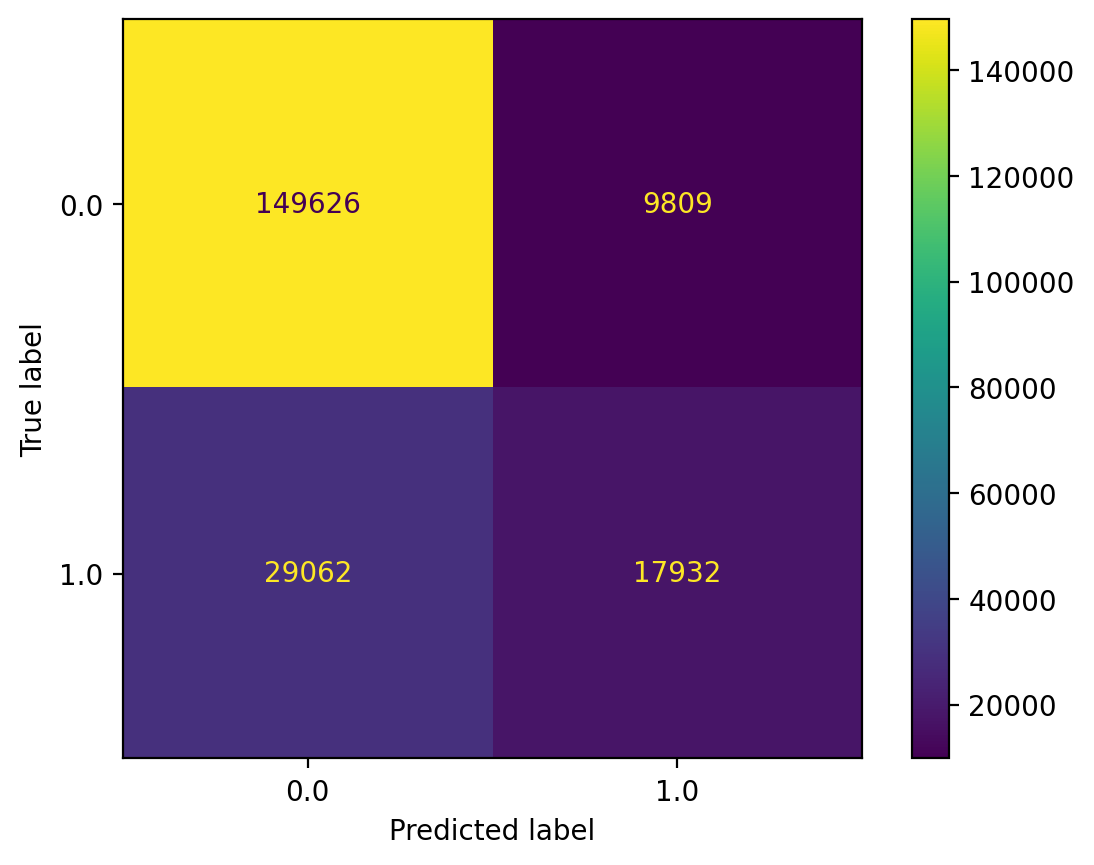

In [ ]:
## LR
lr = LogisticRegression(C=0.001, solver='liblinear')
train_and_test(lr, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89    159435
         1.0       0.64      0.48      0.55     46994

    accuracy                           0.82    206429
   macro avg       0.75      0.70      0.72    206429
weighted avg       0.81      0.82      0.81    206429

AUC ROC: 0.7016111212819643


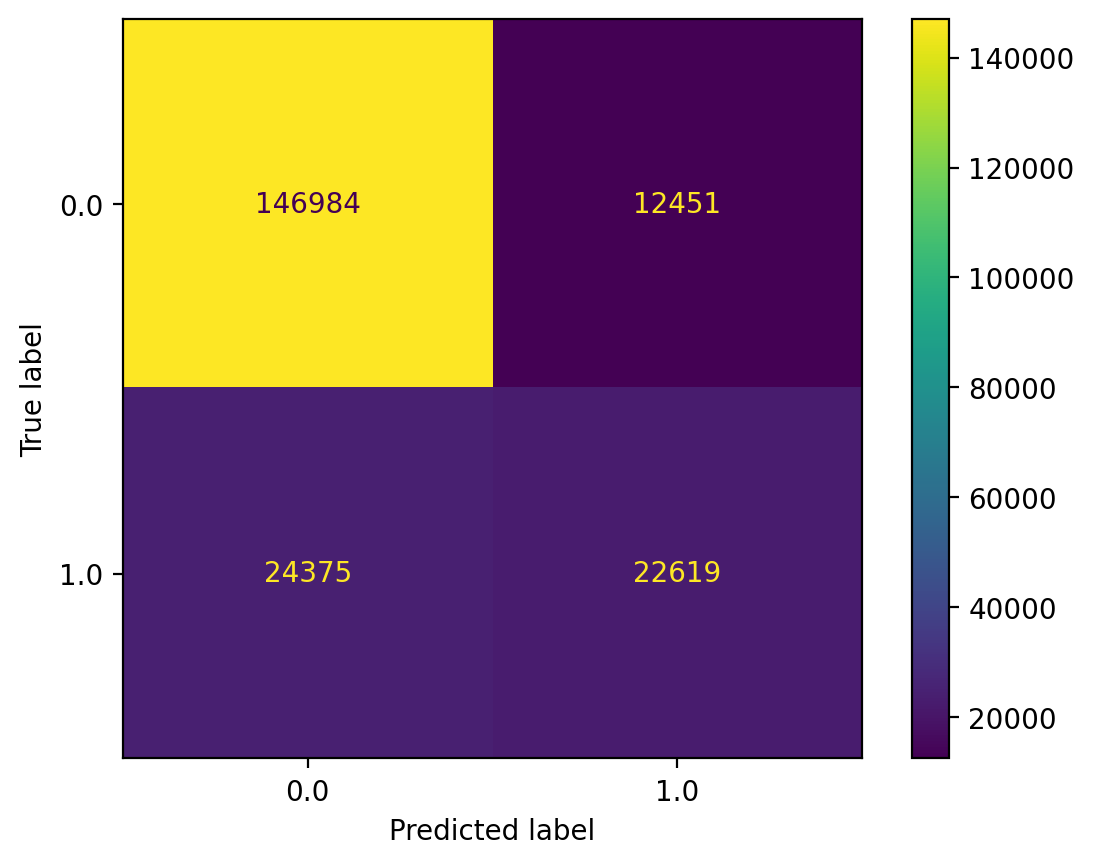

In [ ]:
# NB
nb = GaussianNB(var_smoothing=1.232846739442066e-08)
train_and_test(nb, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91    159435
         1.0       0.65      0.84      0.73     46994

    accuracy                           0.86    206429
   macro avg       0.80      0.85      0.82    206429
weighted avg       0.88      0.86      0.87    206429

AUC ROC: 0.8539483478599024


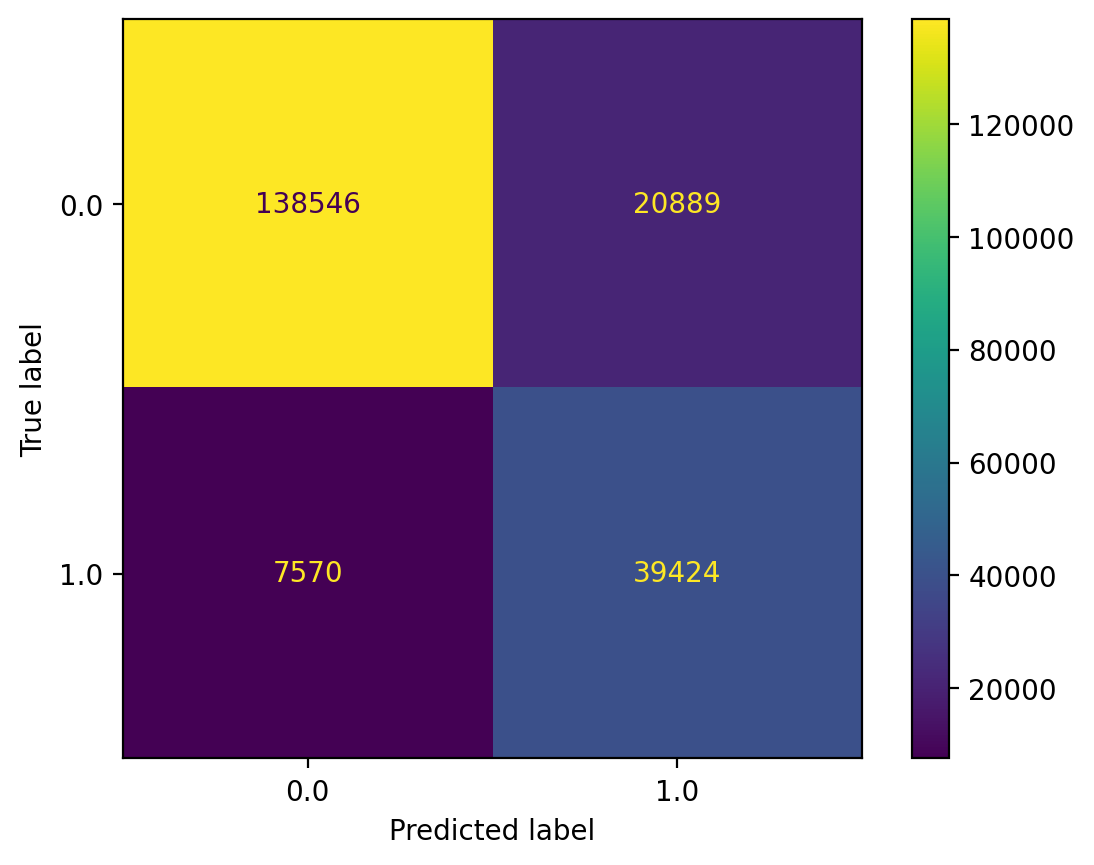

In [ ]:
# DT
dt = DecisionTreeClassifier(max_depth=20, min_samples_leaf=100)
train_and_test(dt, X_train, y_train, X_test, y_test)

## Resultados tras eliminar duplicados y muestras con valores faltantes

Vamos ahora a realizar el mismo trabajo sobre el dataset resultante de eliminar duplicados y muestras faltantes, en lugar de utilizar la imputación de valores.

Primero recuperamos ese dataset, eliminamos las muestras duplicadas y con valores faltantes, transformamos las variables categóricas a numéricas de la misma manera y realizamos después el estandarizado.

In [ ]:
# Transform the categorical features to numerical using one-hot encoding for the variable Source, and label encoding for the variable 'Color'
color_cat = ['Colorless', 'Near Colorless', 'Faint Yellow', 'Light Yellow', 'Yellow']

ord_enc = OrdinalEncoder(categories=[color_cat])

df['Color'] = ord_enc.fit_transform(df['Color'].values.reshape(-1,1))

# Check the unique values of the variable 'Color'
print(df['Color'].unique())

[2. 3. 0. 1. 4.]


In [ ]:
# Apply one-hot encoding to the variable 'Source' using the get_dummies function
df = pd.get_dummies(df, columns=['Source'], drop_first=True, prefix='Source', prefix_sep='_', dtype='int')

# Check the new columns
print(df.columns)

Index(['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Color',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Water Temperature',
       'Air Temperature', 'Target', 'Source_Ground', 'Source_Lake',
       'Source_Reservoir', 'Source_River', 'Source_Spring', 'Source_Stream',
       'Source_Well'],
      dtype='object')


In [ ]:
y = df['Target']

X = df.drop(columns=['Target'])

print(X.shape)
print(y.shape)

(722916, 25)
(722916,)


In [ ]:
# Standardize the features
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X.describe()

pH          Iron       Nitrate      Chloride          Lead  \
count  7.229160e+05  7.229160e+05  7.229160e+05  7.229160e+05  7.229160e+05   
mean   2.295052e-15 -1.245511e-16 -3.075248e-16  6.235418e-16 -9.632265e-18   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -6.369103e+00 -2.570894e-01 -1.851505e+00 -2.320567e+00 -4.289055e-02   
25%   -6.305787e-01 -2.570691e-01 -6.798254e-01 -6.760885e-01 -4.289055e-02   
50%    4.477314e-03 -2.524417e-01 -1.633103e-01 -1.079901e-01 -4.289055e-02   
75%    6.515586e-01 -1.449130e-01  4.828809e-01  5.150014e-01 -4.289055e-02   
max    6.430400e+00  3.537318e+01  2.035878e+01  1.901806e+01  1.179478e+02   

               Zinc         Color     Turbidity      Fluoride        Copper  \
count  7.229160e+05  7.229160e+05  7.229160e+05  7.229160e+05  7.229160e+05   
mean   3.762088e-16 -7.847348e-17  7.123945e-17  2.134825e-17  6.958820e-17   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -1.017313e+00 -1.075126e+00 -5.603119e-01 -1.187884e+00 -8.733744e-01   
25%   -7.418853e-01 -1.075126e+00 -5.173196e-01 -7.203155e-01 -6.505289e-01   
50%   -3.016485e-01 -2.739376e-01 -3.289752e-01 -2.215278e-01 -2.735665e-01   
75%    4.572886e-01  5.272513e-01  1.260318e-01  4.758660e-01  3.273052e-01   
max    1.786732e+01  2.129629e+00  2.184643e+01  1.504780e+01  1.810189e+01   

       ...  Total Dissolved Solids  Water Temperature  Air Temperature  \
count  ...            7.229160e+05       7.229160e+05     7.229160e+05   
mean   ...           -4.481166e-16      -2.321474e-16     3.307749e-16   
std    ...            1.000001e+00       1.000001e+00     1.000001e+00   
min    ...           -1.715764e+00      -1.570889e+00    -5.193703e+00   
25%    ...           -8.614619e-01      -6.849775e-01    -6.744223e-01   
50%    ...           -7.792116e-03      -2.361503e-01    -5.769376e-04   
75%    ...            8.434300e-01       4.137850e-01     6.744419e-01   
max    ...            2.041898e+00       1.684689e+01     4.648229e+00   

       Source_Ground   Source_Lake  Source_Reservoir  Source_River  \
count   7.229160e+05  7.229160e+05      7.229160e+05  7.229160e+05   
mean   -1.030161e-16  7.619810e-17     -1.889103e-17  4.731605e-17   
std     1.000001e+00  1.000001e+00      1.000001e+00  1.000001e+00   
min    -3.783623e-01 -3.768008e-01     -3.771215e-01 -3.780421e-01   
25%    -3.783623e-01 -3.768008e-01     -3.771215e-01 -3.780421e-01   
50%    -3.783623e-01 -3.768008e-01     -3.771215e-01 -3.780421e-01   
75%    -3.783623e-01 -3.768008e-01     -3.771215e-01 -3.780421e-01   
max     2.642969e+00  2.653922e+00      2.651665e+00  2.645208e+00   

       Source_Spring  Source_Stream   Source_Well  
count   7.229160e+05   7.229160e+05  7.229160e+05  
mean    1.215828e-17   9.573292e-18 -4.078970e-17  
std     1.000001e+00   1.000001e+00  1.000001e+00  
min    -3.773727e-01  -3.791049e-01 -3.785462e-01  
25%    -3.773727e-01  -3.791049e-01 -3.785462e-01  
50%    -3.773727e-01  -3.791049e-01 -3.785462e-01  
75%    -3.773727e-01  -3.791049e-01 -3.785462e-01  
max     2.649900e+00   2.637792e+00  2.641685e+00  

[8 rows x 25 columns]

In [ ]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Save the train and test datasets to use the same during the modeling phase
X_train.to_csv(f'{path}/X_train2.csv', index=False)
X_test.to_csv(f'{path}/X_test2.csv', index=False)
y_train.to_csv(f'{path}/y_train2.csv', index=False)
y_test.to_csv(f'{path}/y_test2.csv', index=False)

In [ ]:
# Read the train and test datasets
X_train = pd.read_csv(f'{path}/X_train2.csv')
X_test = pd.read_csv(f'{path}/X_test2.csv')
y_train = pd.read_csv(f'{path}/y_train2.csv')
y_test = pd.read_csv(f'{path}/y_test2.csv')

In [ ]:
# Change y to a 1D array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [ ]:
# Check the shape of the datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(578332, 25)
(144584, 25)
(578332,)
(144584,)


In [ ]:
# Use the same models and hyperparameters as before, to train again the models
# Dictionary to store the best models
best_models2 = {}

In [ ]:
## Logistic Regression
best_models2['LR'] = train_and_report('LR', '2', k, score)

In [ ]:
## Naive Bayes
best_models2['NB'] = train_and_report('NB', '2', k, score)

In [ ]:
## K-Nearest Neighbors
best_models2['KNN'] = train_and_report('KNN', '2', k, score)

In [ ]:
## Decision Tree
best_models2['DT'] = train_and_report('DT', '2', k, score)

In [ ]:
## Random Forest
best_models2['RF'] = train_and_report('RF', '2', k, score)

In [ ]:
# Print the best models
print(best_models2)

Lo idóneo sería volver a utilizar GridSearchCV para encontrar la mejor combinación de hiperparámetros. No obstante, en vez de volver a ejecutar todo, vamos a utilizar los modelos base, sin hiperparámetros ya que consume mucho tiempo de computación.

              precision    recall  f1-score   support

           0       0.84      0.94      0.88    111694
           1       0.64      0.38      0.48     32890

    accuracy                           0.81    144584
   macro avg       0.74      0.66      0.68    144584
weighted avg       0.79      0.81      0.79    144584

AUC ROC: 0.6584584896396048


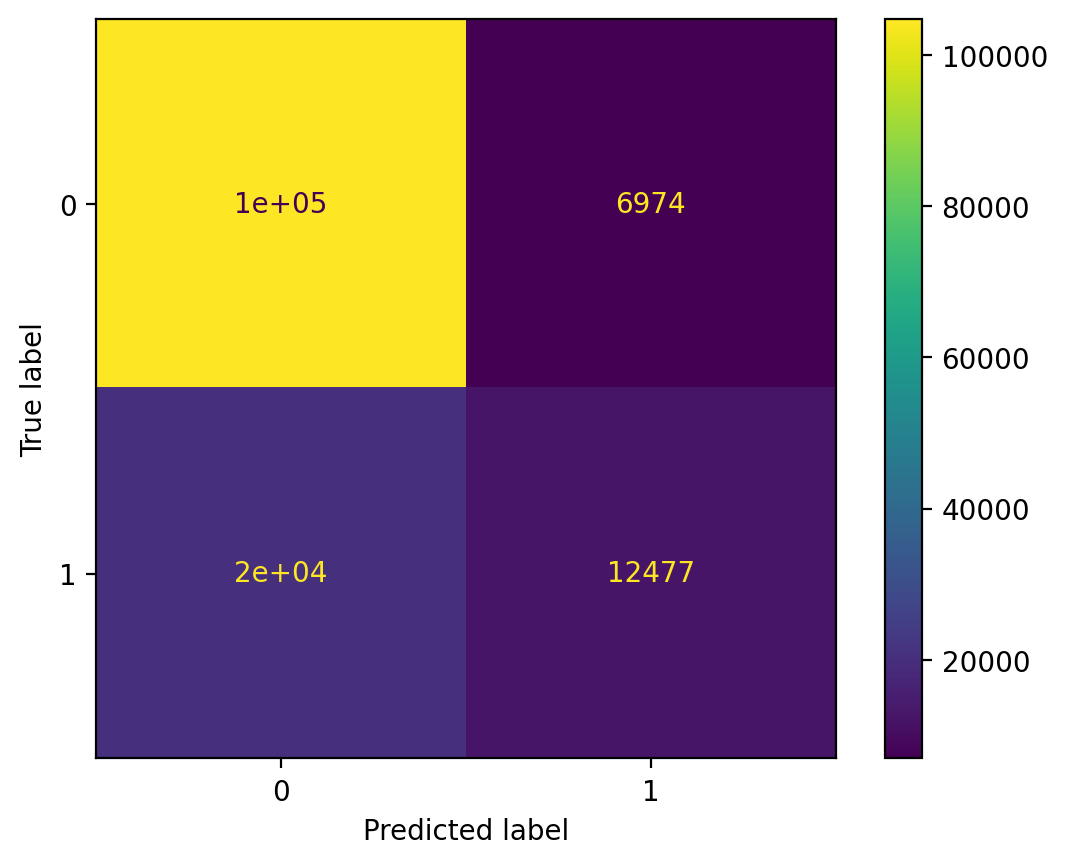

In [ ]:
# LR
lr = LogisticRegression()
train_and_test(lr, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89    111694
           1       0.64      0.49      0.55     32890

    accuracy                           0.82    144584
   macro avg       0.75      0.70      0.72    144584
weighted avg       0.81      0.82      0.81    144584

AUC ROC: 0.7028770674393303


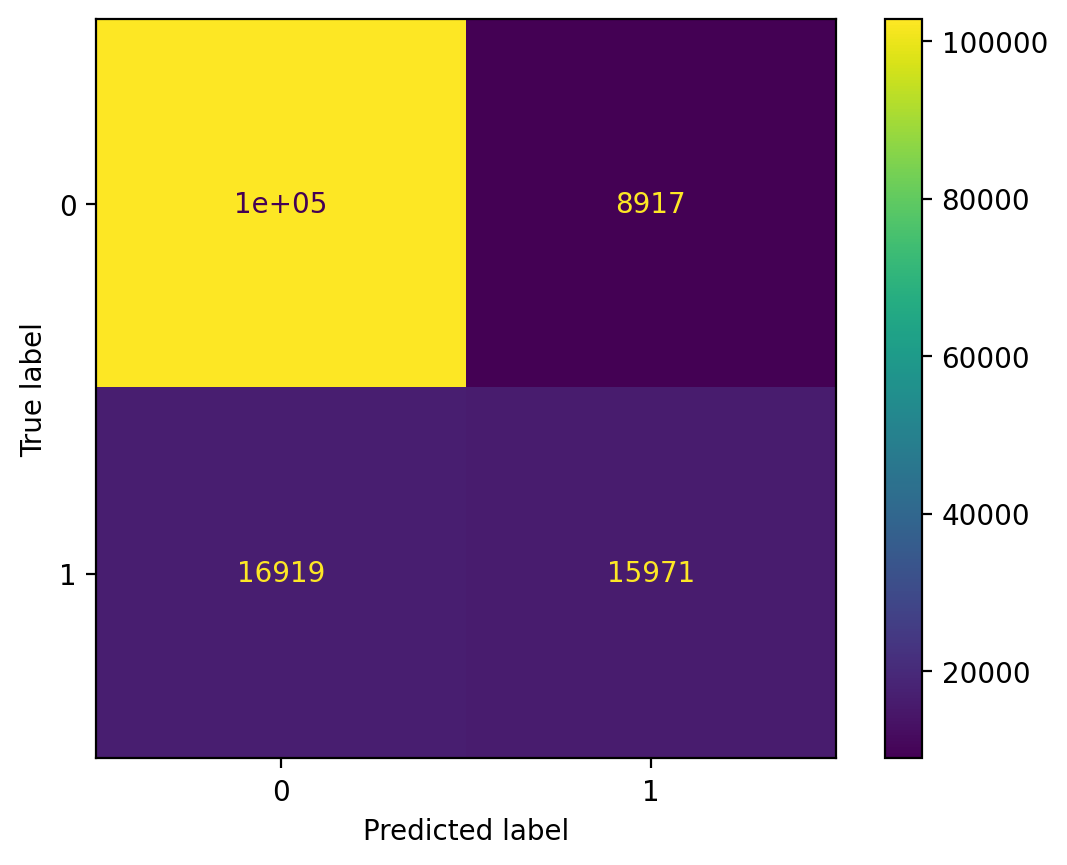

In [ ]:
# NB
nb = GaussianNB()
train_and_test(nb, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89    111694
           1       0.63      0.62      0.62     32890

    accuracy                           0.83    144584
   macro avg       0.76      0.76      0.76    144584
weighted avg       0.83      0.83      0.83    144584

AUC ROC: 0.756113840172382


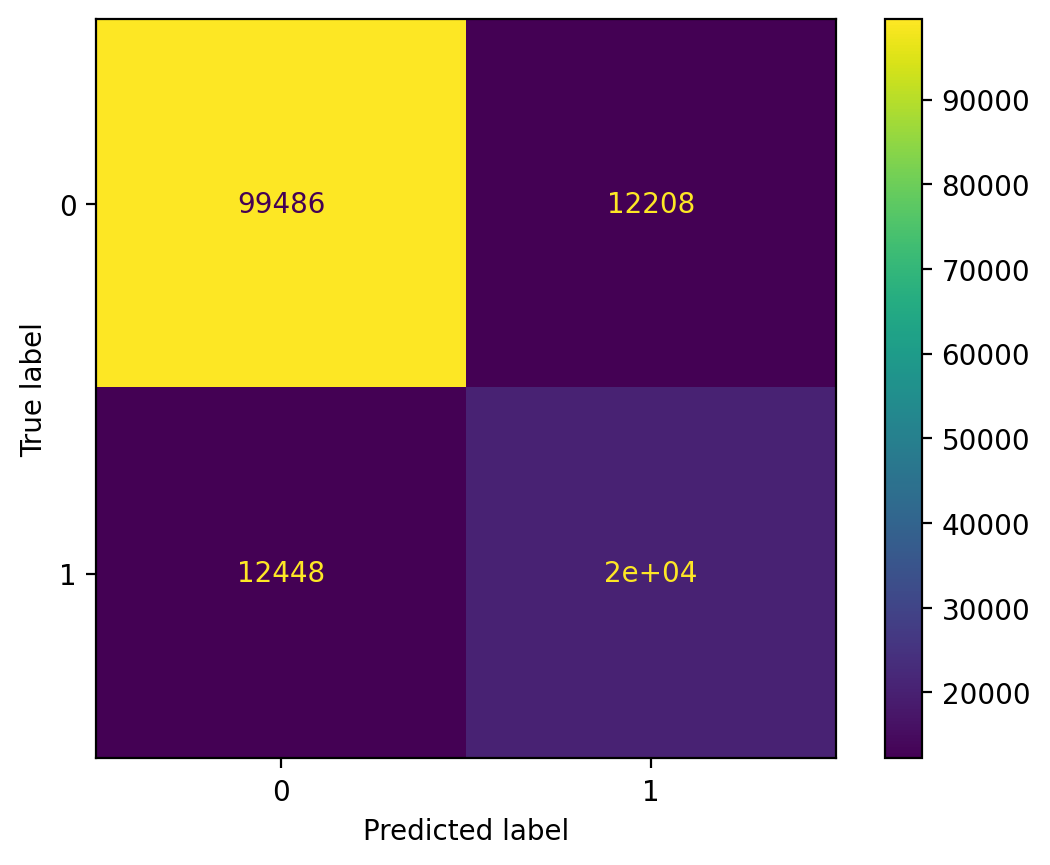

In [ ]:
# DT
dt = DecisionTreeClassifier()
train_and_test(dt, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    111694
           1       0.64      0.96      0.77     32890

    accuracy                           0.87    144584
   macro avg       0.81      0.90      0.84    144584
weighted avg       0.91      0.87      0.88    144584

AUC ROC: 0.902266764074062


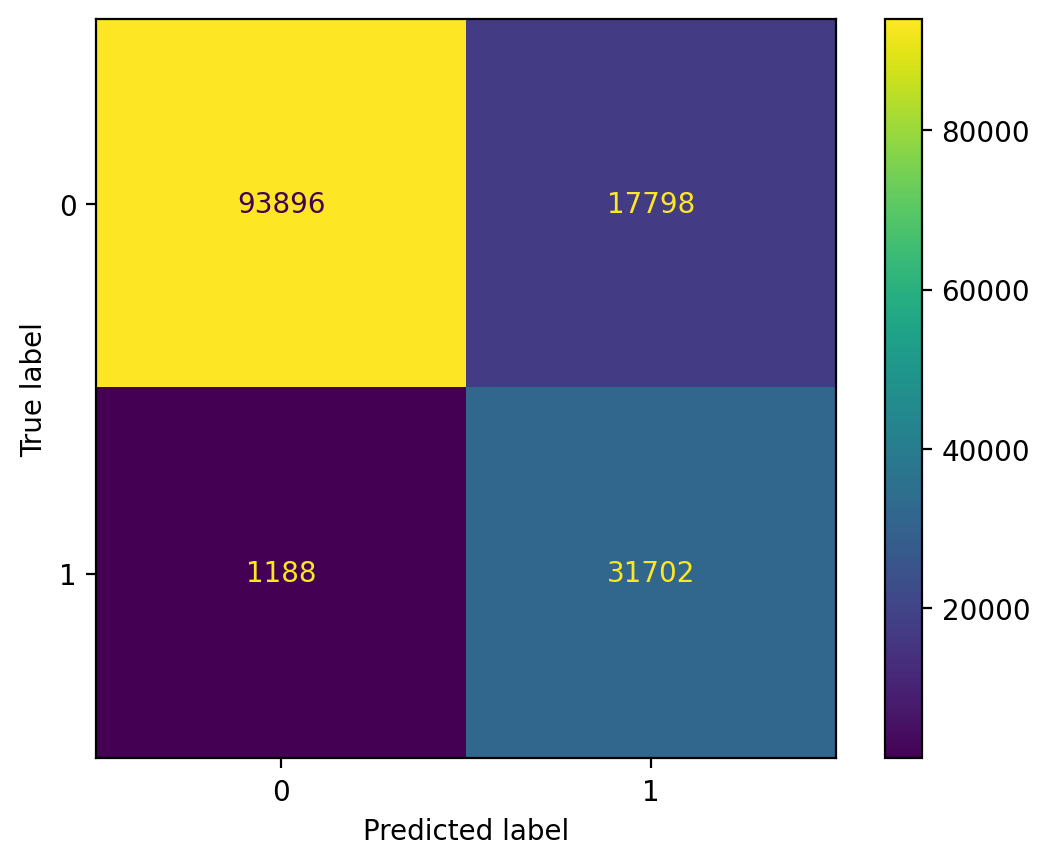

In [ ]:
# RF
rf = RandomForestClassifier()
train_and_test(rf, X_train, y_train, X_test, y_test)

## Resultados tras equilibrar muestras (50-50)

Vamos también a comprobar qué ocurre con las métricas si equilibramos el dataset de manera que tengamos 50% de muestras de agua potable y 50% de agua no potable.

In [ ]:
# Select all the samples with label 1 and the same amount of samples with label 0
df_balanced = pd.concat([df[df['Target']==1],
                        df[df['Target']==0].sample(n=df[df['Target']==1].shape[0], random_state=42)])

In [ ]:
# Get train and test splits
y = df_balanced['Target']

X = df_balanced.drop(columns=['Target'])

print(X.shape)
print(y.shape)

# Standardize the features
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X.describe()

(328902, 25)
(328902,)


pH          Iron       Nitrate      Chloride          Lead  \
count  3.289020e+05  3.289020e+05  3.289020e+05  3.289020e+05  3.289020e+05   
mean   7.183589e-16  5.098421e-18 -1.698898e-16 -3.750364e-17  1.490640e-17   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -5.420329e+00 -2.963698e-01 -1.667551e+00 -2.121532e+00 -5.441261e-02   
25%   -6.111136e-01 -2.963470e-01 -6.709180e-01 -6.797138e-01 -5.441261e-02   
50%    7.081152e-03 -2.911041e-01 -1.955195e-01 -1.478822e-01 -5.441261e-02   
75%    6.332084e-01 -1.687051e-01  4.239254e-01  4.636586e-01 -5.441261e-02   
max    5.510311e+00  2.797620e+01  1.766273e+01  1.656771e+01  8.894930e+01   

               Zinc         Color     Turbidity      Fluoride        Copper  \
count  3.289020e+05  3.289020e+05  3.289020e+05  3.289020e+05  3.289020e+05   
mean   2.025542e-16  5.219400e-17  5.530491e-17 -2.789441e-16 -1.109555e-16   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -9.766430e-01 -1.173446e+00 -5.822416e-01 -1.134883e+00 -8.583338e-01   
25%   -7.204009e-01 -1.173446e+00 -5.410423e-01 -7.106908e-01 -6.547190e-01   
50%   -3.088751e-01 -4.323270e-01 -3.597749e-01 -2.467648e-01 -3.035903e-01   
75%    4.116909e-01  1.049910e+00  9.714342e-02  4.254690e-01  2.856173e-01   
max    1.623143e+01  1.791029e+00  1.701118e+01  1.263350e+01  1.511666e+01   

       ...  Total Dissolved Solids  Water Temperature  Air Temperature  \
count  ...            3.289020e+05       3.289020e+05     3.289020e+05   
mean   ...            5.033611e-16      -2.916470e-18     4.976955e-16   
std    ...            1.000002e+00       1.000002e+00     1.000002e+00   
min    ...           -1.717108e+00      -1.571359e+00    -5.193897e+00   
25%    ...           -8.609545e-01      -6.847538e-01    -6.762547e-01   
50%    ...           -6.914691e-03      -2.364690e-01    -3.880555e-04   
75%    ...            8.440668e-01       4.127579e-01     6.746512e-01   
max    ...            1.912688e+00       1.648679e+01     4.644917e+00   

       Source_Ground   Source_Lake  Source_Reservoir  Source_River  \
count   3.289020e+05  3.289020e+05      3.289020e+05  3.289020e+05   
mean    7.271731e-17 -4.523228e-17      4.292611e-17 -6.048974e-18   
std     1.000002e+00  1.000002e+00      1.000002e+00  1.000002e+00   
min    -3.785434e-01 -3.770985e-01     -3.779343e-01 -3.773667e-01   
25%    -3.785434e-01 -3.770985e-01     -3.779343e-01 -3.773667e-01   
50%    -3.785434e-01 -3.770985e-01     -3.779343e-01 -3.773667e-01   
75%    -3.785434e-01 -3.770985e-01     -3.779343e-01 -3.773667e-01   
max     2.641705e+00  2.651827e+00      2.645963e+00  2.649943e+00   

       Source_Spring  Source_Stream   Source_Well  
count   3.289020e+05   3.289020e+05  3.289020e+05  
mean    4.930994e-17  -5.260447e-17  4.655550e-17  
std     1.000002e+00   1.000002e+00  1.000002e+00  
min    -3.775034e-01  -3.794353e-01 -3.786064e-01  
25%    -3.775034e-01  -3.794353e-01 -3.786064e-01  
50%    -3.775034e-01  -3.794353e-01 -3.786064e-01  
75%    -3.775034e-01  -3.794353e-01 -3.786064e-01  
max     2.648983e+00   2.635495e+00  2.641265e+00  

[8 rows x 25 columns]

In [ ]:
# Split the samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Save the train and test datasets to use the same during the modeling phase
X_train.to_csv(f'{path}/X_train3.csv', index=False)
X_test.to_csv(f'{path}/X_test3.csv', index=False)
y_train.to_csv(f'{path}/y_train3.csv', index=False)
y_test.to_csv(f'{path}/y_test3.csv', index=False)

In [ ]:
# Read the train and test datasets
X_train = pd.read_csv(f'{path}/X_train3.csv')
X_test = pd.read_csv(f'{path}/X_test3.csv')
y_train = pd.read_csv(f'{path}/y_train3.csv')
y_test = pd.read_csv(f'{path}/y_test3.csv')

In [ ]:
# Change y to a 1D array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [ ]:
# Print the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(263121, 25)
(263121,)
(65781, 25)
(65781,)


              precision    recall  f1-score   support

           0       0.77      0.83      0.80     32891
           1       0.82      0.76      0.79     32890

    accuracy                           0.79     65781
   macro avg       0.80      0.79      0.79     65781
weighted avg       0.80      0.79      0.79     65781

AUC ROC: 0.7939976884870625


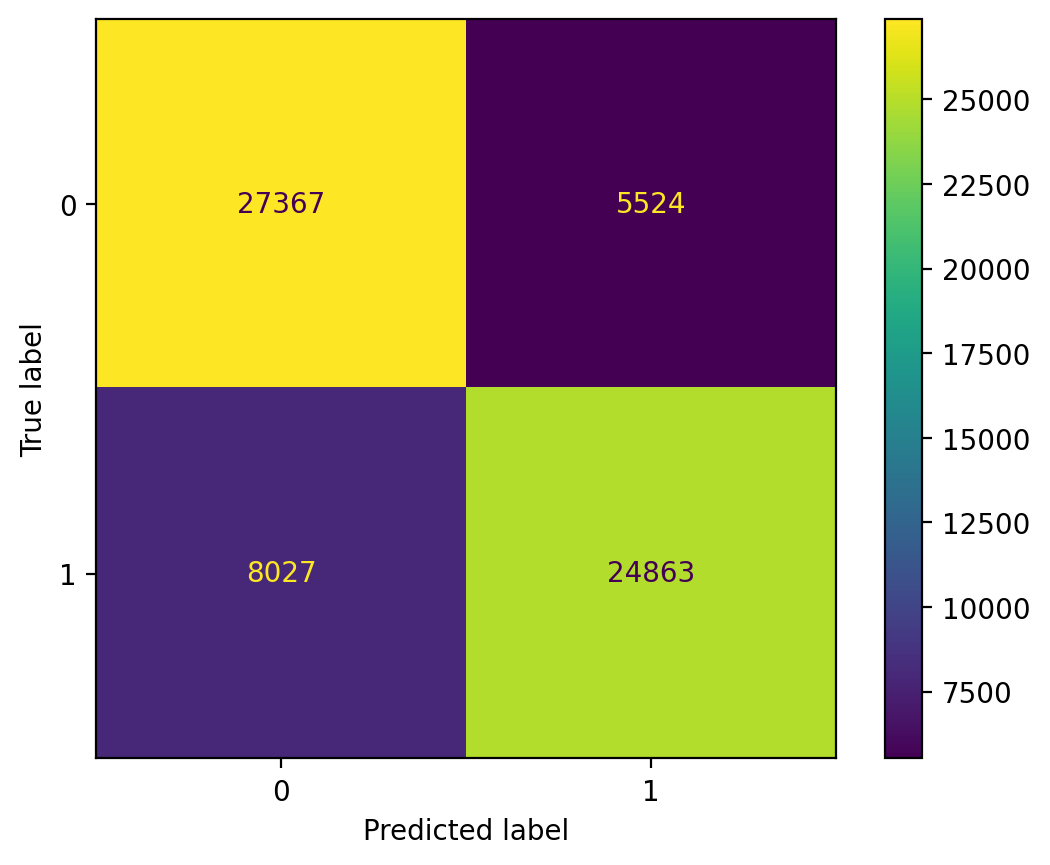

In [ ]:
# Train LR without params
lr = LogisticRegression()
train_and_test(lr, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.67      0.91      0.77     32891
           1       0.86      0.55      0.67     32890

    accuracy                           0.73     65781
   macro avg       0.76      0.73      0.72     65781
weighted avg       0.76      0.73      0.72     65781

AUC ROC: 0.7303905325955762


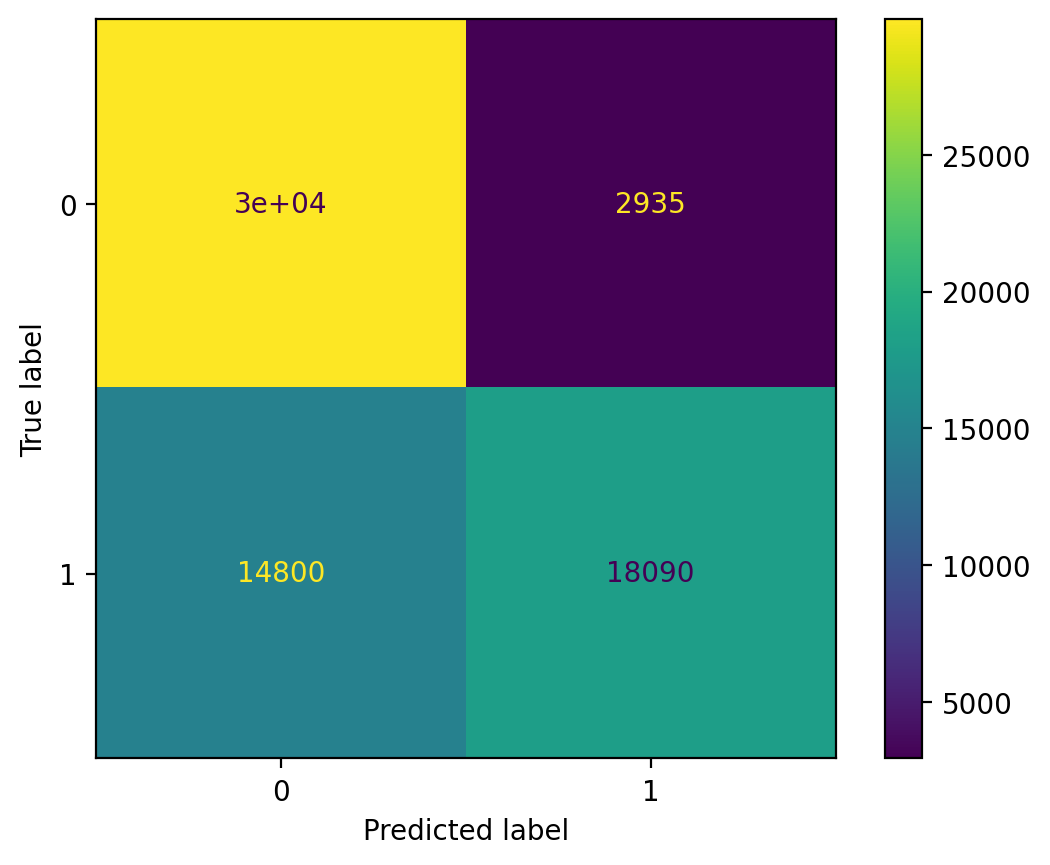

In [ ]:
# Train NB without params
nb = GaussianNB()
train_and_test(nb, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84     32891
           1       0.85      0.83      0.84     32890

    accuracy                           0.84     65781
   macro avg       0.84      0.84      0.84     65781
weighted avg       0.84      0.84      0.84     65781

AUC ROC: 0.8375061018363733


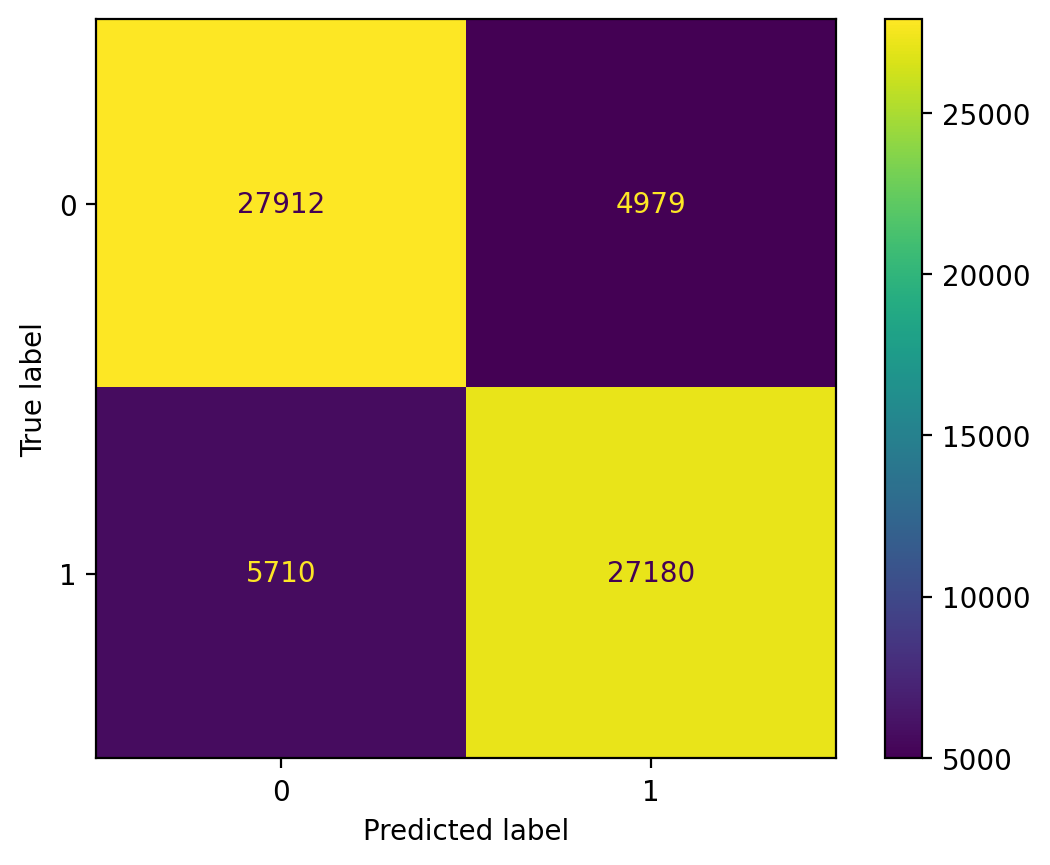

In [ ]:
# Train DT without params
dt = DecisionTreeClassifier()
train_and_test(dt, X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     32891
           1       0.86      0.99      0.92     32890

    accuracy                           0.91     65781
   macro avg       0.92      0.91      0.91     65781
weighted avg       0.92      0.91      0.91     65781

AUC ROC: 0.9102031781749902


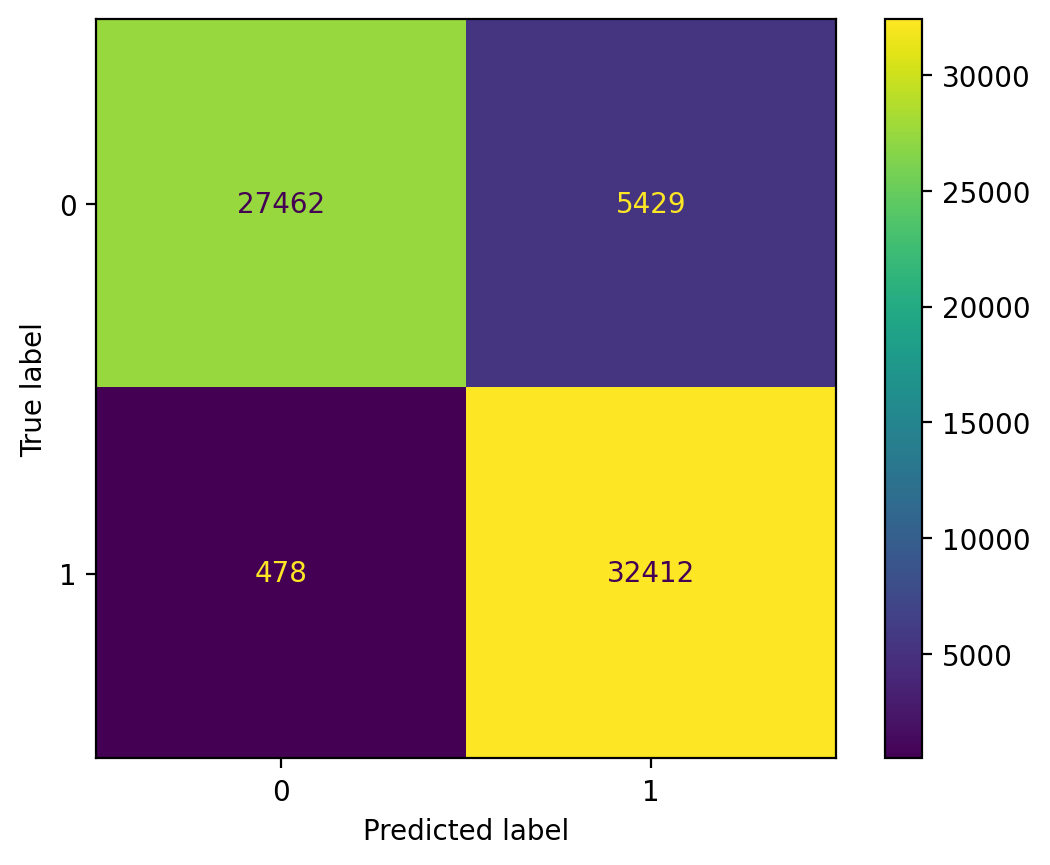

In [ ]:
# Train RF without params
rf = RandomForestClassifier()
train_and_test(rf, X_train, y_train, X_test, y_test)

Al equilibrar las muestras y tener 50% de agua potable y 50% de agua no potable, podemos ver que sin necesidad de ajustar los hiperparámetros obtenemos resultados parecidos e incluso mejores que con los anteriores datasets en términos de AUC ROC. Esto indica que la sensibilidad y especificidad del clasificador son mejores de forma equilibrada.

También se observa un aumento de la exactitud (accuracy) global de los modelos, sobre todo en el caso de Random Forest.

## Aprendizaje no supervisado

En este caso tenemos las muestras etiquetadas, pero si no fuese así podríamos utilizar técnicas de aprendizaje supervisado para clasificar las muestras en agua potable y no potable. De esta manera conseguiríamos las etiquetas de las muestras y podríamos desarrollar modelos de aprendizaje supervisado posteriormente.

Vamos a utilizar una técnica de clustering para agrupar las muestras en dos grupos, en concreto K-means. Dado que tenemos muchas muestras en el dataset vamos a utilizar el dataset tras eliminar valores perdidos y valores duplicados.

In [ ]:
# Read the X_train, X_test
X_train = pd.read_csv(f'{path}/X_train2.csv')
X_test = pd.read_csv(f'{path}/X_test2.csv')

# Read the y_train and y_test to check the labels
y_train = pd.read_csv(f'{path}/y_train2.csv')
y_test = pd.read_csv(f'{path}/y_test2.csv')

In [ ]:
# Print the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(578332, 25)
(578332, 1)
(144584, 25)
(144584, 1)


In [ ]:
# Configuration. The parameter init='k-means++' improves convergence
kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++',n_init='auto')
kmeans.fit(X_train)

KMeans(n_clusters=2, n_init='auto', random_state=0)

In [ ]:
# Centroid coordinates
print("Centroides")
print(kmeans.cluster_centers_)
# inercia
print("\n Inercia = ", kmeans.inertia_)

Centroides
[[ 4.25364615e-02 -1.52623610e-01 -1.63709441e-01 -1.97756608e-01
  -3.46369851e-02 -8.12082188e-02 -2.75324892e-01 -2.09500421e-01
  -1.72325482e-01 -2.09323183e-01 -1.45678719e-01 -1.28488325e-01
   9.51062576e-04 -1.39866456e-01 -1.62321935e-01 -8.04676603e-02
   8.22828288e-04 -1.71130246e-03 -3.20210412e-03 -3.13940220e-04
  -1.33544816e-03  1.56091628e-03 -1.43350822e-04  5.27208906e-04
   3.92701559e-04]
 [-1.30572828e-01  4.58332051e-01  4.91515871e-01  5.99313070e-01
   1.05186749e-01  2.44213149e-01  8.27420412e-01  6.32240494e-01
   5.18435180e-01  6.27251694e-01  4.36482909e-01  3.82909495e-01
   1.96073191e-03  4.20461108e-01  4.87717520e-01  2.42642052e-01
   3.91435651e-03  3.50564051e-04  4.58468015e-03 -9.95517054e-04
   5.42470200e-03 -3.39440653e-03  3.09080011e-03  3.68780900e-04
  -4.23060758e-03]]

 Inercia =  13809750.238561552


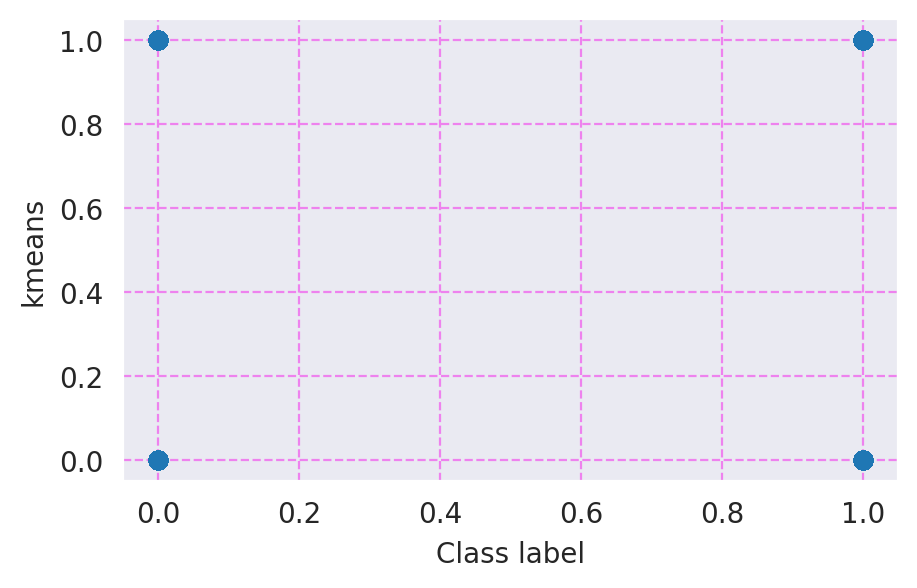

In [ ]:
# Etiquetas observadas versus cluster
plt.figure(figsize=(5,3))
plt.plot(y_train, kmeans.labels_, marker='o',linestyle='None')
plt.xlabel('Class label')
plt.ylabel('kmeans')
plt.show()

Aquí se puede ver que las muestras se han repartido en los clústeres creados por k-means. Vamos a obtener el report con las métricas obtenidas.

              precision    recall  f1-score   support

           0       0.90      0.87      0.88    446771
           1       0.60      0.66      0.63    131561

    accuracy                           0.82    578332
   macro avg       0.75      0.76      0.76    578332
weighted avg       0.83      0.82      0.83    578332



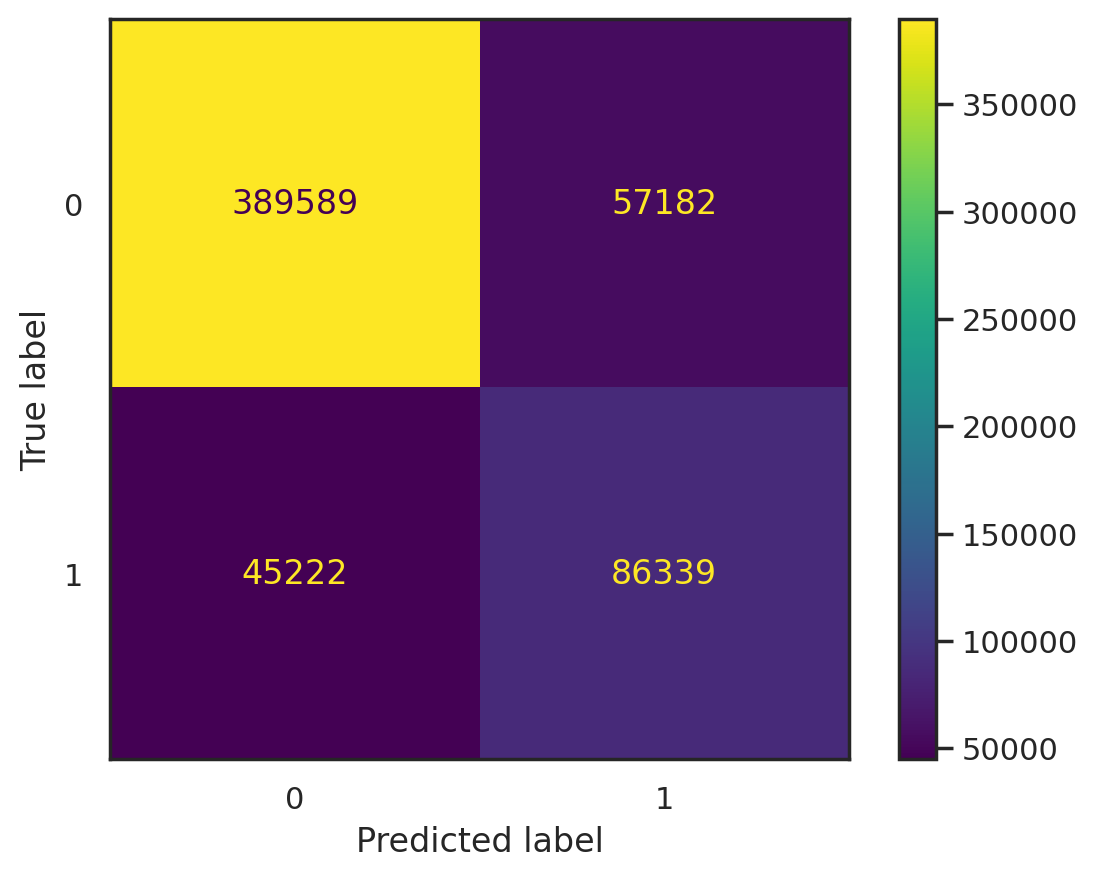

In [ ]:
print(classification_report(y_train, kmeans.labels_))

# Get the confusion matrix
cm = confusion_matrix(y_train, kmeans.labels_)
# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# Remove the grid when plotting
sns.set(style="white")
# Plot the confusion matrix
disp.plot()

Las métricas obtenidas son adecuadas y similares a las obtenidas por las técnicas de aprendizaje supervisado ejecutadas anteriormente.

Vamos ahora predecir las etiquetas de las muestras separadas para test y obtener las métricas de rendimiento.

In [ ]:
# Predict with k-means
y_pred = kmeans.predict(X_test)

# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88    111694
           1       0.60      0.66      0.63     32890

    accuracy                           0.82    144584
   macro avg       0.75      0.76      0.75    144584
weighted avg       0.83      0.82      0.82    144584



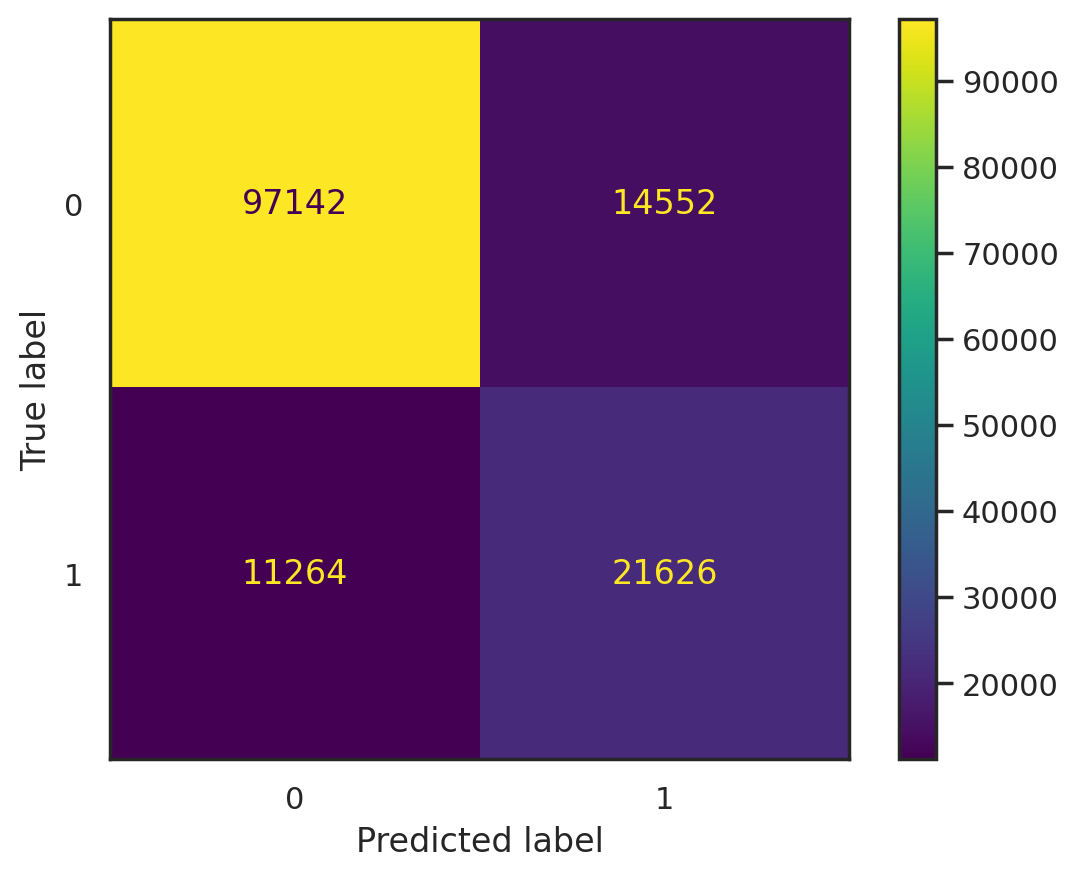

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# Remove the grid when plotting
sns.set(style="white")
# Plot the confusion matrix
disp.plot()

Las métricas obtenidas en el conjunto de test son prácticamente identicas a las obtenidas en el conjunto de entrenamiento.

## Conclusiones

Antes de comenzar con el desarrollo de modelos de aprendizaje automático, es fundamental estudiar y comprender los datos para procesarlos adecuadamente y elegir la mejor estrategia de entrenamiento. Además, es crucial establecer el objetivo del sistema desde el principio: ¿queremos un modelo altamente capaz de detectar los casos positivos, aun si eso significa cometer errores en los casos negativos? ¿O preferimos un modelo que detecte ambas clases de manera equilibrada? Definir estos objetivos nos ayuda a guiar la selección de modelos y métricas de evaluación adecuadas.

En caso de no disponer de las etiquetas, podemos utilizar técnicas de aprendizaje no supervisado para obtenerlas y posteriormente desarrollar algoritmos de aprendizaje supervisado. Es importante recordar también, que si el número de características es elevado, podemos utilizar la técnica de PCA para reducir su número y procesar nuestros datos.